d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [03:51:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [03:51:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


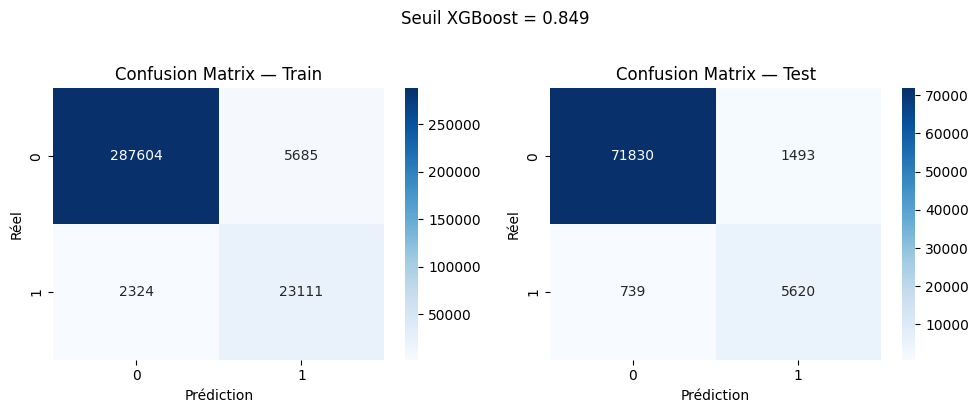

In [4]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# 1) Charger les données
df = pd.read_csv("final_df_encoded.csv")
X = df.drop(columns=["churn", "subscriber_id"])
y = df["churn"]

# 2) Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Charger le modèle et le seuil (déjà entraîné)
xgb_model     = joblib.load("xgb_model.pkl")
xgb_threshold = joblib.load("xgb_threshold.pkl")["best_threshold"]

# 4) Prédire directement sans refit, en convertissant en .values
y_proba_train = xgb_model.predict_proba(X_train.values)[:, 1]
y_proba_test  = xgb_model.predict_proba(X_test.values)[:, 1]

y_pred_train = (y_proba_train >= xgb_threshold).astype(int)
y_pred_test  = (y_proba_test  >= xgb_threshold).astype(int)

# 5) Matrices de confusion
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test  = confusion_matrix(y_test,  y_pred_test)

fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[0,1], yticklabels=[0,1])
axes[0].set_title("Confusion Matrix — Train")
axes[0].set_xlabel("Prédiction")
axes[0].set_ylabel("Réel")

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=[0,1], yticklabels=[0,1])
axes[1].set_title("Confusion Matrix — Test")
axes[1].set_xlabel("Prédiction")
axes[1].set_ylabel("Réel")

plt.suptitle(f"Seuil XGBoost = {xgb_threshold:.3f}", y=1.02)
plt.tight_layout()
plt.show()


d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:59:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📋 TRAIN:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96    293289
           1       1.00      0.92      0.96    288790

    accuracy                           0.96    582079
   macro avg       0.96      0.96      0.96    582079
weighted avg       0.96      0.96      0.96    582079


📋 TEST:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     73323
           1       0.92      0.44      0.59      6359

    accuracy                           0.95     79682
   macro avg       0.94      0.72      0.78     79682
weighted avg       0.95      0.95      0.94     79682


📊 Confusion Matrix (TRAIN):
 [[292447    842]
 [ 22085 266705]]

📊 Confusion Matrix (TEST):
 [[73090   233]
 [ 3577  2782]]


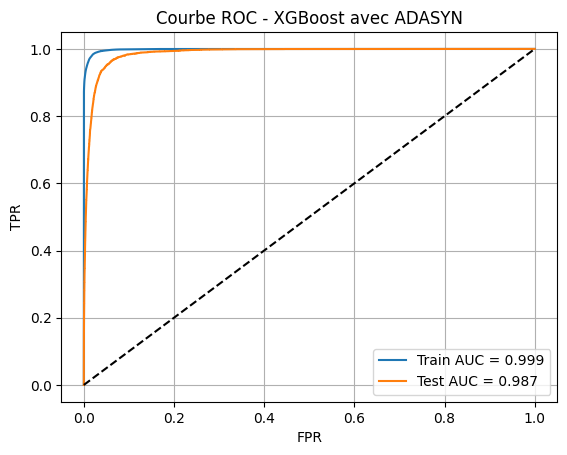

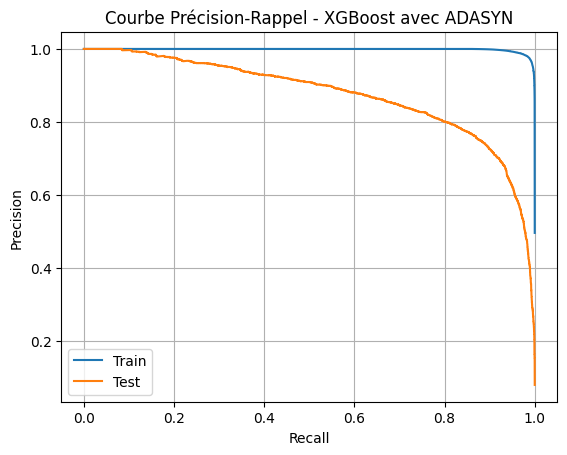

[learning_curve] Training set sizes: [ 38805  90545 142285 194026]


d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:00:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:00:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:00:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:00:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\p

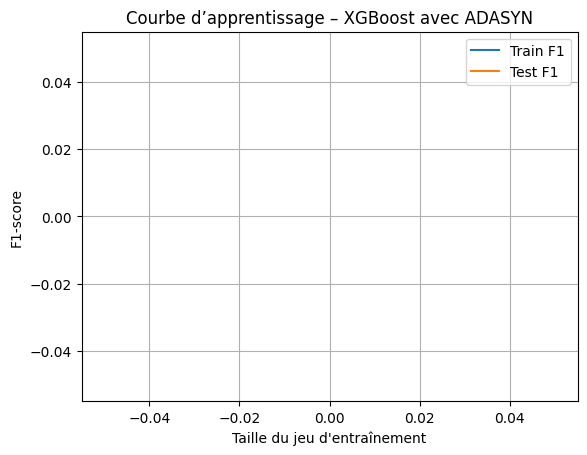

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import (
    roc_curve, auc, classification_report,
    precision_recall_curve, confusion_matrix
)
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier

# === 1. Chargement des données ===
df = pd.read_csv("final_df_encoded.csv")

# === 2. Définir les features et la cible ===
X = df.drop(columns=["subscriber_id", "churn"])
y = df["churn"]

# === 3. Nettoyage des noms de colonnes (interdits pour XGBoost) ===
X.columns = X.columns.str.replace(r"[\[\]<>]", "_", regex=True)

# === 4. Split train/test stratifié ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === 5. ADASYN pour rééquilibrer les classes ===
adasyn = ADASYN(random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)

# === 6. Chargement du modèle XGBoost et du seuil optimal ===
xgb_model = joblib.load("xgb_model.pkl")
xgb_model.set_params(tree_method="hist", device="cpu")
xgb_threshold = joblib.load("xgb_threshold.pkl")["best_threshold"]

# === 7. Réentrainement du modèle ===
xgb_model.fit(X_train_res, y_train_res)

# === 8. Prédictions ===
y_proba_train = xgb_model.predict_proba(X_train_res)[:, 1]
y_pred_train = (y_proba_train >= xgb_threshold).astype(int)

y_proba_test = xgb_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= xgb_threshold).astype(int)

# === 9. Évaluation textuelle ===
print("\n📋 TRAIN:\n", classification_report(y_train_res, y_pred_train))
print("\n📋 TEST:\n", classification_report(y_test, y_pred_test))

# === 10. Matrices de confusion ===
print("\n📊 Confusion Matrix (TRAIN):\n", confusion_matrix(y_train_res, y_pred_train))
print("\n📊 Confusion Matrix (TEST):\n", confusion_matrix(y_test, y_pred_test))

# === 11. Courbe ROC ===
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Courbe ROC - XGBoost avec ADASYN")
plt.legend()
plt.grid()
plt.show()

# === 12. Courbe Précision-Rappel ===
prec_train, rec_train, _ = precision_recall_curve(y_train_res, y_proba_train)
prec_test, rec_test, _ = precision_recall_curve(y_test, y_proba_test)

plt.figure()
plt.plot(rec_train, prec_train, label="Train")
plt.plot(rec_test, prec_test, label="Test")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Précision-Rappel - XGBoost avec ADASYN")
plt.legend()
plt.grid()
plt.show()

# === 13. Courbes d’apprentissage (corrigé pour éviter TerminatedWorkerError) ===
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model,
    X_train_res,
    y_train_res,
    cv=3,
    scoring='f1',
    train_sizes=np.linspace(0.1, 0.5, 4),  # réduction à 50%
    n_jobs=1,  # exécution mono-thread pour stabilité
    verbose=1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label="Train F1")
plt.plot(train_sizes, test_mean, label="Test F1")
plt.xlabel("Taille du jeu d'entraînement")
plt.ylabel("F1-score")
plt.title("Courbe d’apprentissage – XGBoost avec ADASYN")
plt.legend()
plt.grid()
plt.show()


d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:02:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


TRAIN:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96    293289
           1       1.00      0.92      0.96    288790

    accuracy                           0.96    582079
   macro avg       0.96      0.96      0.96    582079
weighted avg       0.96      0.96      0.96    582079

TEST:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     73323
           1       0.92      0.44      0.59      6359

    accuracy                           0.95     79682
   macro avg       0.94      0.72      0.78     79682
weighted avg       0.95      0.95      0.94     79682

Confusion Matrix (Train):
 [[292447    842]
 [ 22085 266705]]
Confusion Matrix (Test):
 [[73090   233]
 [ 3577  2782]]


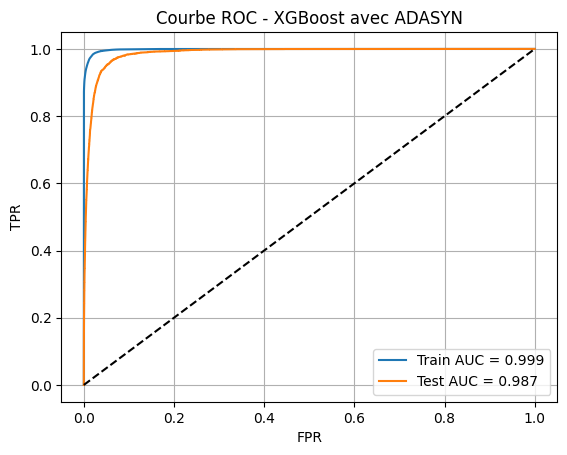

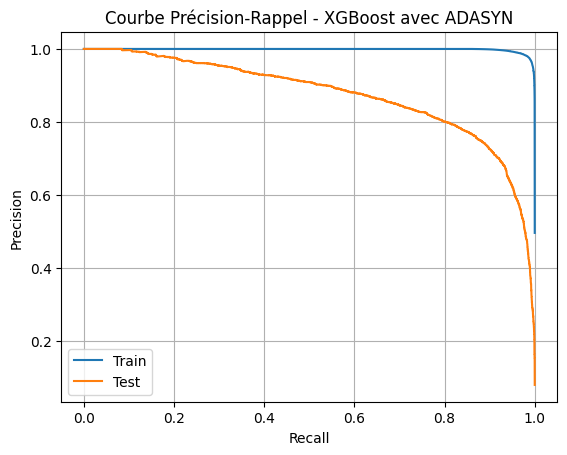

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, classification_report,
    precision_recall_curve, confusion_matrix
)
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier

# 1. Chargement des données
df = pd.read_csv("final_df_encoded.csv")
X = df.drop(columns=["subscriber_id", "churn"])
y = df["churn"]
X.columns = X.columns.str.replace(r"[\[\]<>]", "_", regex=True)

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 3. ADASYN
adasyn = ADASYN(random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)

# 4. Modèle et seuil
xgb_model = joblib.load("xgb_model.pkl")
xgb_model.set_params(tree_method="hist", device="cpu")
xgb_threshold = joblib.load("xgb_threshold.pkl")["best_threshold"]

# 5. Entraînement
xgb_model.fit(X_train_res, y_train_res)

# 6. Prédictions
y_proba_train = xgb_model.predict_proba(X_train_res)[:, 1]
y_pred_train = (y_proba_train >= xgb_threshold).astype(int)
y_proba_test = xgb_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= xgb_threshold).astype(int)

# 7. Classification report
print("TRAIN:\n", classification_report(y_train_res, y_pred_train))
print("TEST:\n", classification_report(y_test, y_pred_test))

# 8. Confusion Matrix
print("Confusion Matrix (Train):\n", confusion_matrix(y_train_res, y_pred_train))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_test))

# 9. ROC
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)

plt.figure()
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc(fpr_train, tpr_train):.3f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc(fpr_test, tpr_test):.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Courbe ROC - XGBoost avec ADASYN")
plt.legend()
plt.grid()
plt.show()

# 10. Précision-Rappel
prec_train, rec_train, _ = precision_recall_curve(y_train_res, y_proba_train)
prec_test, rec_test, _ = precision_recall_curve(y_test, y_proba_test)

plt.figure()
plt.plot(rec_train, prec_train, label="Train")
plt.plot(rec_test, prec_test, label="Test")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Précision-Rappel - XGBoost avec ADASYN")
plt.legend()
plt.grid()
plt.show()


📈 Apprentissage (f1)...


d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:04:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:04:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:04:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:04:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\p

📈 Apprentissage (precision)...


d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:05:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\p

📈 Apprentissage (recall)...


d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:07:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\p

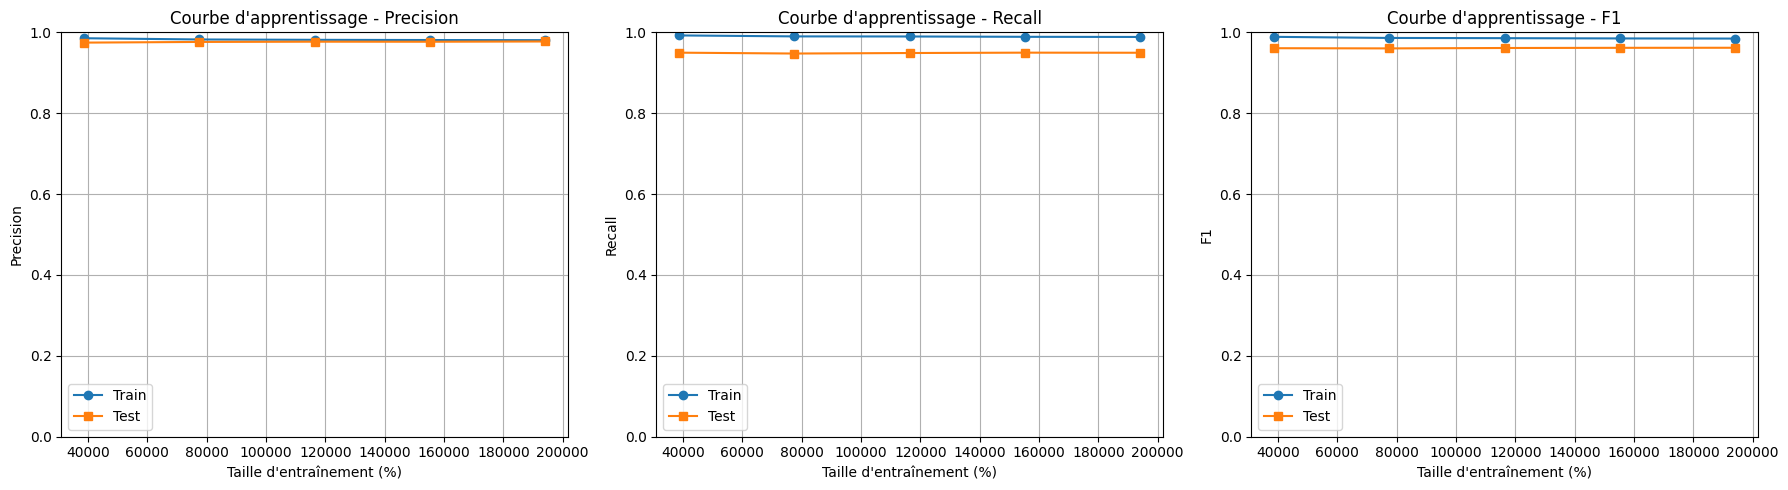

In [10]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

metrics = {
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score)
}

train_sizes = np.linspace(0.1, 0.5, 5)  # max 50% pour éviter crash

results = {}

for name, scorer in metrics.items():
    print(f"📈 Apprentissage ({name})...")
    train_sizes_out, train_scores, test_scores = learning_curve(
        estimator=xgb_model,
        X=X_train_res,
        y=y_train_res,
        train_sizes=train_sizes,
        scoring=scorer,
        cv=3,
        shuffle=True,
        random_state=42,
        n_jobs=1  # mono-thread pour éviter TerminatedWorkerError
    )
    results[name] = {
        "train_sizes": train_sizes_out,
        "train_scores": np.mean(train_scores, axis=1),
        "test_scores": np.mean(test_scores, axis=1)
    }

# === Affichage graphique ===
plt.figure(figsize=(18, 5))

for i, metric in enumerate(["precision", "recall", "f1"]):
    plt.subplot(1, 3, i + 1)
    plt.plot(results[metric]["train_sizes"], results[metric]["train_scores"], label="Train", marker='o')
    plt.plot(results[metric]["train_sizes"], results[metric]["test_scores"], label="Test", marker='s')
    plt.xlabel("Taille d'entraînement (%)")
    plt.ylabel(metric.capitalize())
    plt.title(f"Courbe d'apprentissage - {metric.capitalize()}")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


## LGB

[LightGBM] [Info] Number of positive: 288790, number of negative: 293289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14790
[LightGBM] [Info] Number of data points in the train set: 582079, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496135 -> initscore=-0.015459
[LightGBM] [Info] Start training from score -0.015459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

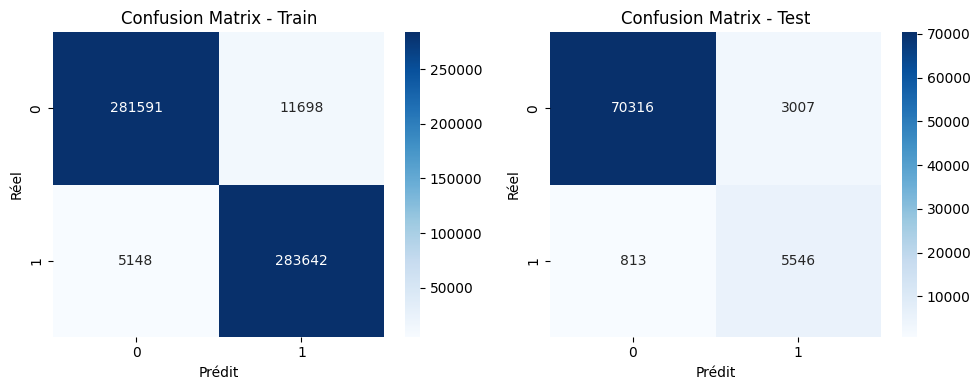

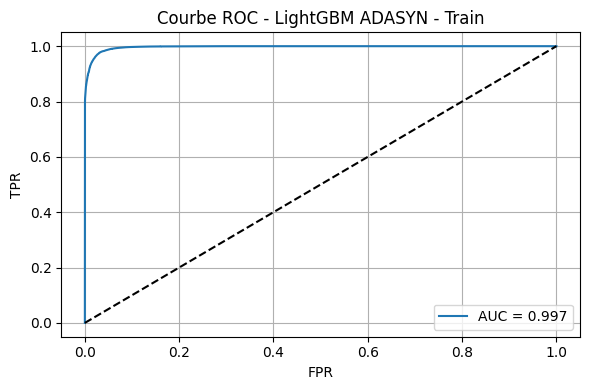

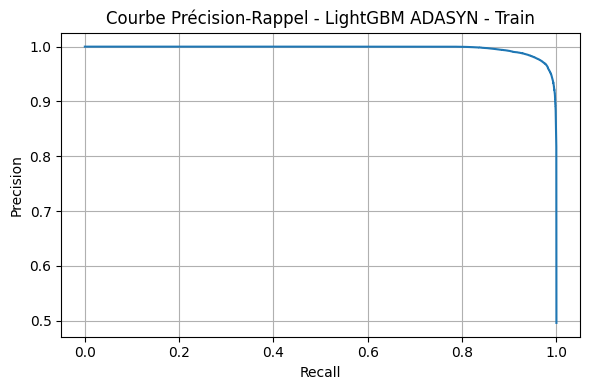

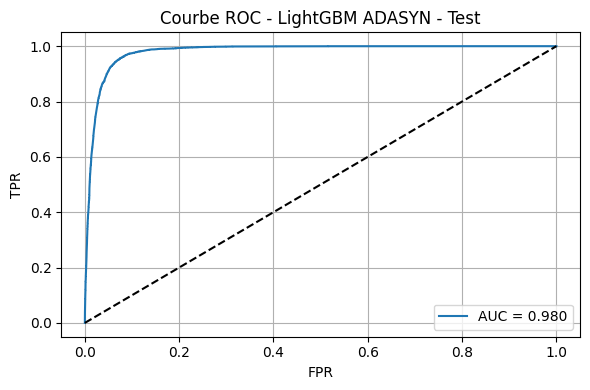

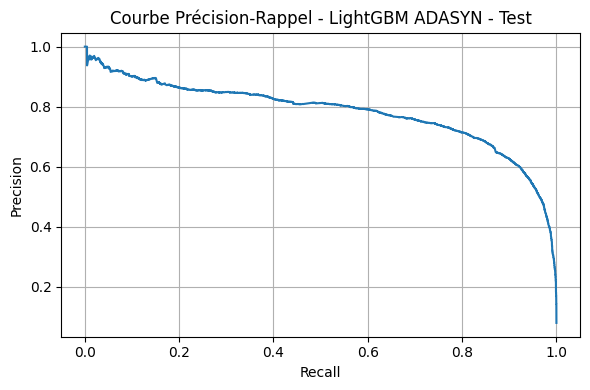

Courbe d'apprentissage:   0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 29499, number of negative: 29329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14222
[LightGBM] [Info] Number of data points in the train set: 58828, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501445 -> initscore=0.005780
[LightGBM] [Info] Start training from score 0.005780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Courbe d'apprentissage:  11%|█         | 1/9 [00:02<00:16,  2.05s/it]

[LightGBM] [Info] Number of positive: 58494, number of negative: 58657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14439
[LightGBM] [Info] Number of data points in the train set: 117151, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499304 -> initscore=-0.002783
[LightGBM] [Info] Start training from score -0.002783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Courbe d'apprentissage:  22%|██▏       | 2/9 [00:05<00:21,  3.04s/it]

[LightGBM] [Info] Number of positive: 88295, number of negative: 87987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14587
[LightGBM] [Info] Number of data points in the train set: 176282, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500874 -> initscore=0.003494
[LightGBM] [Info] Start training from score 0.003494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Courbe d'apprentissage:  33%|███▎      | 3/9 [00:11<00:25,  4.17s/it]

[LightGBM] [Info] Number of positive: 119049, number of negative: 117315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14759
[LightGBM] [Info] Number of data points in the train set: 236364, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503668 -> initscore=0.014673
[LightGBM] [Info] Start training from score 0.014673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Courbe d'apprentissage:  44%|████▍     | 4/9 [00:20<00:30,  6.05s/it]

[LightGBM] [Info] Number of positive: 147663, number of negative: 146644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14783
[LightGBM] [Info] Number of data points in the train set: 294307, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501731 -> initscore=0.006925
[LightGBM] [Info] Start training from score 0.006925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Courbe d'apprentissage:  56%|█████▌    | 5/9 [00:32<00:32,  8.15s/it]

[LightGBM] [Info] Number of positive: 176201, number of negative: 175973
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14784
[LightGBM] [Info] Number of data points in the train set: 352174, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500324 -> initscore=0.001295
[LightGBM] [Info] Start training from score 0.001295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Courbe d'apprentissage:  67%|██████▋   | 6/9 [00:47<00:31, 10.67s/it]

[LightGBM] [Info] Number of positive: 203979, number of negative: 205302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14787
[LightGBM] [Info] Number of data points in the train set: 409281, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498384 -> initscore=-0.006465
[LightGBM] [Info] Start training from score -0.006465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

Courbe d'apprentissage:  78%|███████▊  | 7/9 [01:06<00:26, 13.38s/it]

[LightGBM] [Info] Number of positive: 232513, number of negative: 234631
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14786
[LightGBM] [Info] Number of data points in the train set: 467144, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497733 -> initscore=-0.009068
[LightGBM] [Info] Start training from score -0.009068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

Courbe d'apprentissage:  89%|████████▉ | 8/9 [01:28<00:16, 16.07s/it]

[LightGBM] [Info] Number of positive: 260181, number of negative: 263960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14792
[LightGBM] [Info] Number of data points in the train set: 524141, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496395 -> initscore=-0.014420
[LightGBM] [Info] Start training from score -0.014420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

Courbe d'apprentissage: 100%|██████████| 9/9 [01:55<00:00, 12.82s/it]


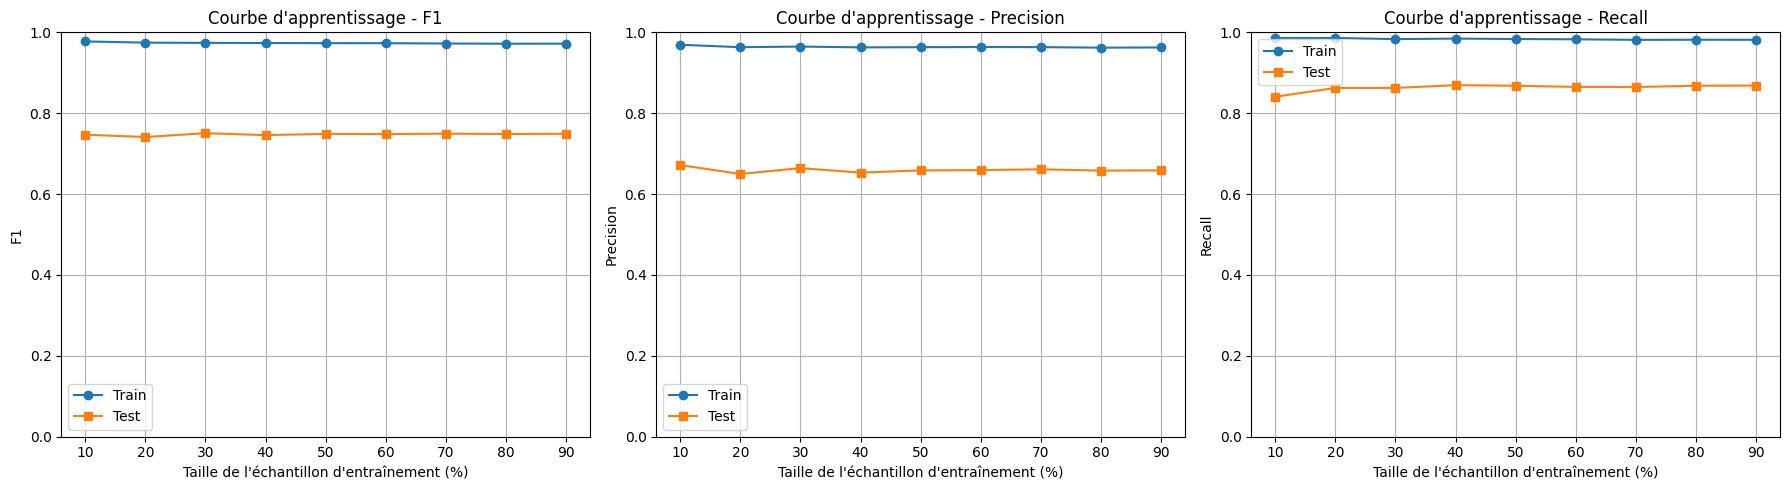

In [11]:
import re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import ADASYN
from tqdm import tqdm
from lightgbm import LGBMClassifier

# === 1. Chargement des données ===
df = pd.read_csv("final_df_encoded.csv")
y = df["churn"]
X = df.drop(columns=["subscriber_id", "churn"])
X.columns = [re.sub(r"[^\w]", "_", col) for col in X.columns]

# === 2. Split stratifié ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === 3. Rééquilibrage avec ADASYN ===
adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train, y_train)

# === 4. Chargement du modèle LightGBM ===
lgb_model = joblib.load("best_model_lgb.pkl")

# === 5. Entraînement sur données équilibrées ===
lgb_model.fit(X_train_bal, y_train_bal)

# === 6. Prédictions ===
y_proba_train = lgb_model.predict_proba(X_train_bal)[:, 1]
y_proba_test = lgb_model.predict_proba(X_test)[:, 1]
y_pred_train = lgb_model.predict(X_train_bal)
y_pred_test = lgb_model.predict(X_test)

# === 7. Évaluation ===
print("📋 TRAIN:\n", classification_report(y_train_bal, y_pred_train))
print("📋 TEST:\n", classification_report(y_test, y_pred_test))

# === 8. Matrices de confusion ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(confusion_matrix(y_train_bal, y_pred_train), annot=True, fmt="d", ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix - Train")
axes[0].set_xlabel("Prédit")
axes[0].set_ylabel("Réel")

sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", ax=axes[1], cmap="Blues")
axes[1].set_title("Confusion Matrix - Test")
axes[1].set_xlabel("Prédit")
axes[1].set_ylabel("Réel")
plt.tight_layout()
plt.show()

# === 9. Courbes ROC & PR ===
def plot_roc_pr(y_true, y_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"Courbe ROC - {title}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Courbe Précision-Rappel - {title}")
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_roc_pr(y_train_bal, y_proba_train, "LightGBM ADASYN - Train")
plot_roc_pr(y_test, y_proba_test, "LightGBM ADASYN - Test")

# === 10. Courbes d’apprentissage ===
train_sizes = np.linspace(0.1, 0.9, 9)
metrics = ["f1", "precision", "recall"]
scores = {m: {"train": [], "test": []} for m in metrics}

for frac in tqdm(train_sizes, desc="Courbe d'apprentissage"):
    X_sub, _, y_sub, _ = train_test_split(X_train, y_train, train_size=frac, stratify=y_train, random_state=42)
    X_res, y_res = adasyn.fit_resample(X_sub, y_sub)

    model = LGBMClassifier(**lgb_model.get_params())
    model.fit(X_res, y_res)

    y_pred_tr = model.predict(X_res)
    y_pred_te = model.predict(X_test)

    scores["f1"]["train"].append(f1_score(y_res, y_pred_tr))
    scores["f1"]["test"].append(f1_score(y_test, y_pred_te))
    scores["precision"]["train"].append(precision_score(y_res, y_pred_tr))
    scores["precision"]["test"].append(precision_score(y_test, y_pred_te))
    scores["recall"]["train"].append(recall_score(y_res, y_pred_tr))
    scores["recall"]["test"].append(recall_score(y_test, y_pred_te))

# === 11. Affichage des courbes d’apprentissage
plt.figure(figsize=(18, 5))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    plt.plot(train_sizes * 100, scores[metric]["train"], label="Train", marker="o")
    plt.plot(train_sizes * 100, scores[metric]["test"], label="Test", marker="s")
    plt.xlabel("Taille de l'échantillon d'entraînement (%)")
    plt.ylabel(metric.capitalize())
    plt.title(f"Courbe d'apprentissage - {metric.capitalize()}")
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Client\AppData\Local\Temp\ipykernel_21776\210619214.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x="Importance", y="Feature", palette="viridis")


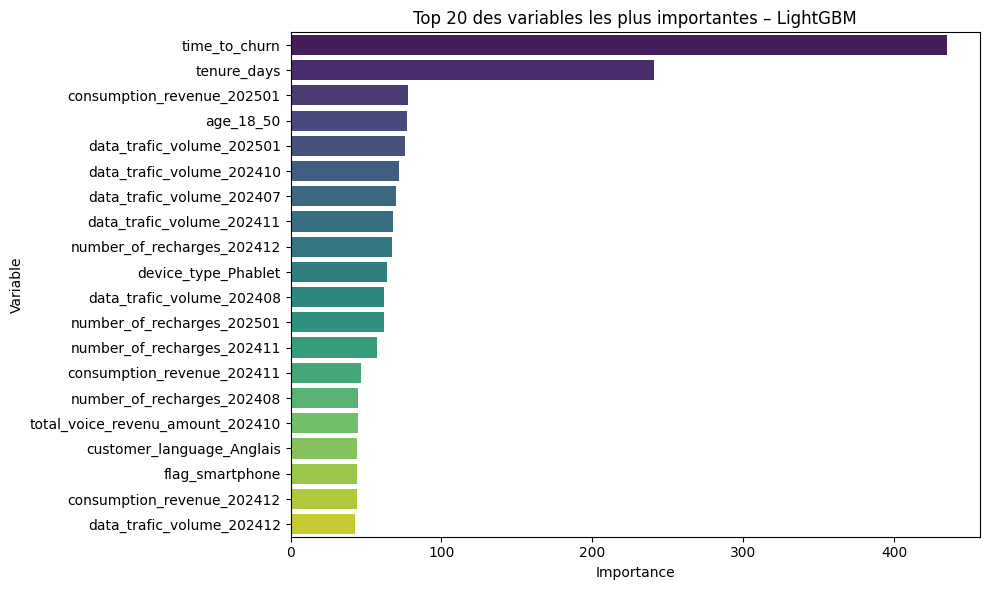

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Récupération des importances ---
importances = lgb_model.feature_importances_  # importance par "gain" par défaut
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# --- 2. Affichage des top 20 variables ---
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(20), x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 des variables les plus importantes – LightGBM")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


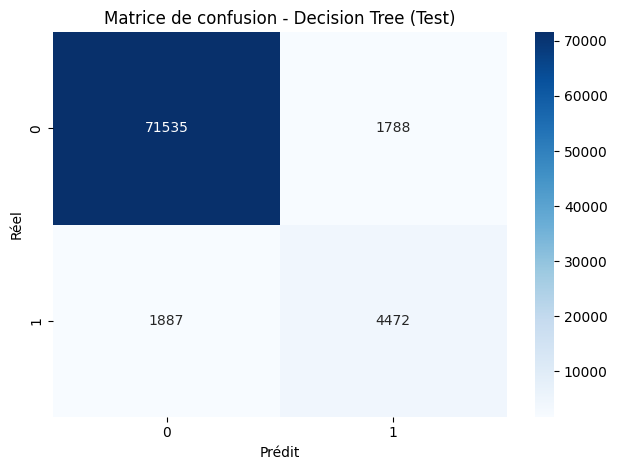

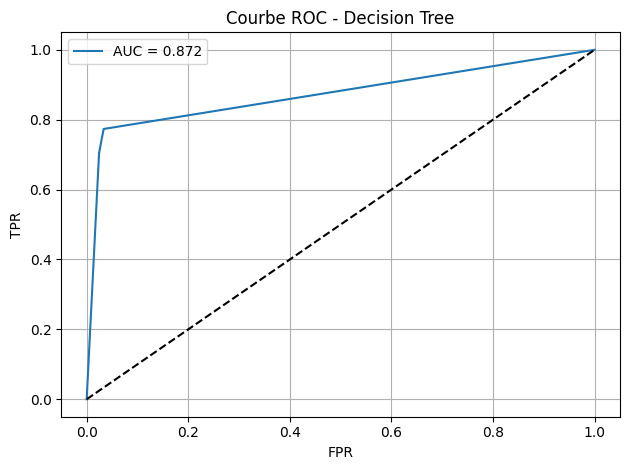

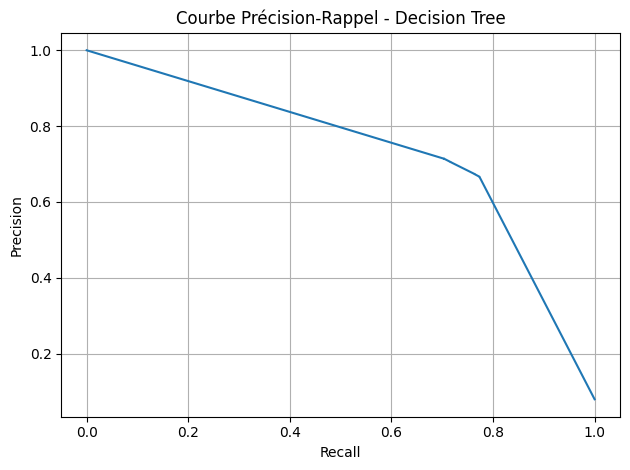

100%|██████████| 9/9 [03:05<00:00, 20.65s/it]


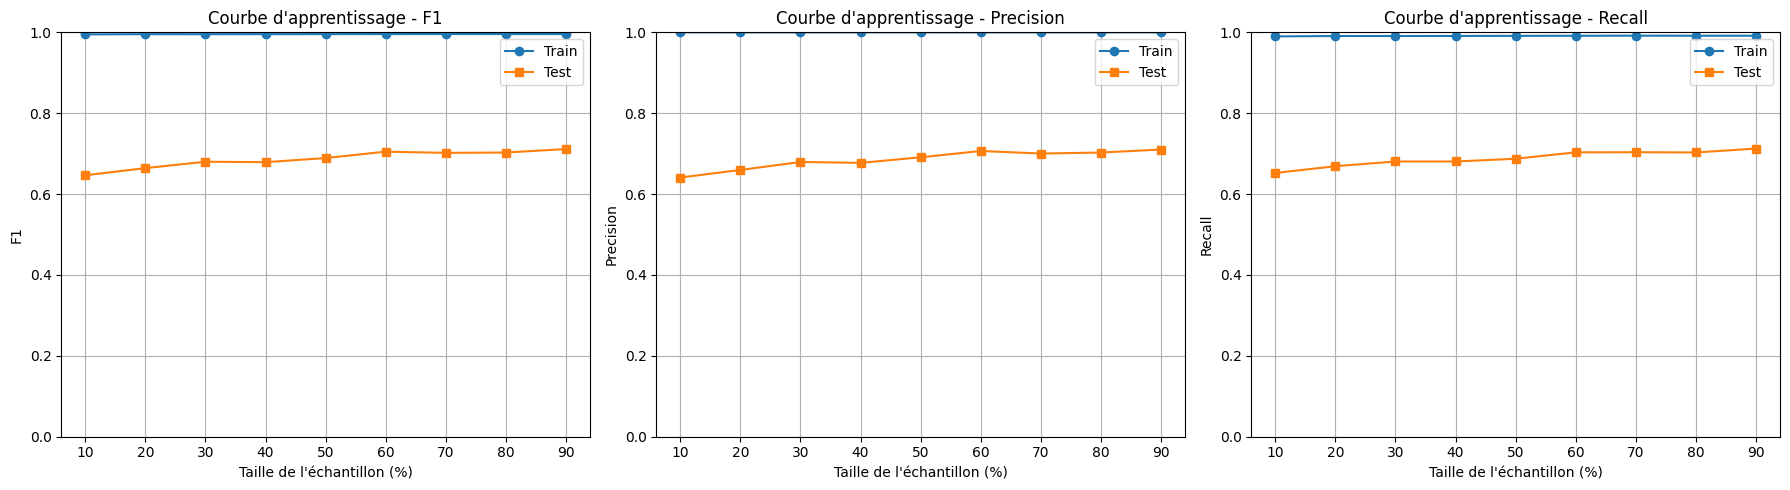

In [13]:
import re
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import ADASYN
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

# === 1. Chargement des données ===
df = pd.read_csv("final_df_encoded.csv")
y = df["churn"]
X = df.drop(columns=["subscriber_id", "churn"])
X.columns = [re.sub(r"[^\w]", "_", col) for col in X.columns]

# === 2. Split stratifié ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# === 3. Rééquilibrage avec ADASYN ===
adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train, y_train)

# === 4. Chargement du modèle ===
dt_model = joblib.load("best_decision_tree.pkl")
dt_model.fit(X_train_bal, y_train_bal)

# === 5. Prédictions ===
y_proba_test = dt_model.predict_proba(X_test)[:, 1]
y_pred_test = dt_model.predict(X_test)

# === 6. Matrice de confusion ===
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - Decision Tree (Test)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

# === 7. ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Courbe ROC - Decision Tree")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === 8. Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Précision-Rappel - Decision Tree")
plt.grid()
plt.tight_layout()
plt.show()

# === 9. Courbes d'apprentissage F1, Precision, Recall ===
train_sizes = np.linspace(0.1, 0.9, 9)
scores = {"f1": {"train": [], "test": []},
          "precision": {"train": [], "test": []},
          "recall": {"train": [], "test": []}}

for frac in tqdm(train_sizes):
    X_sub, _, y_sub, _ = train_test_split(X_train, y_train, train_size=frac, stratify=y_train, random_state=42)
    X_res, y_res = adasyn.fit_resample(X_sub, y_sub)

    model = DecisionTreeClassifier(**dt_model.get_params())
    model.fit(X_res, y_res)

    y_tr = model.predict(X_res)
    y_te = model.predict(X_test)

    scores["f1"]["train"].append(f1_score(y_res, y_tr))
    scores["f1"]["test"].append(f1_score(y_test, y_te))
    scores["precision"]["train"].append(precision_score(y_res, y_tr))
    scores["precision"]["test"].append(precision_score(y_test, y_te))
    scores["recall"]["train"].append(recall_score(y_res, y_tr))
    scores["recall"]["test"].append(recall_score(y_test, y_te))

plt.figure(figsize=(18, 5))
for i, metric in enumerate(["f1", "precision", "recall"], 1):
    plt.subplot(1, 3, i)
    plt.plot(train_sizes * 100, scores[metric]["train"], label="Train", marker="o")
    plt.plot(train_sizes * 100, scores[metric]["test"], label="Test", marker="s")
    plt.xlabel("Taille de l'échantillon (%)")
    plt.ylabel(metric.capitalize())
    plt.title(f"Courbe d'apprentissage - {metric.capitalize()}")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()


In [14]:
# === 5 bis. Rapport de classification ===
from sklearn.metrics import classification_report

# Train
y_pred_train = dt_model.predict(X_train_bal)
print("\n📋 Rapport de classification – TRAIN :\n")
print(classification_report(y_train_bal, y_pred_train, digits=4))

# Test
print("\n📋 Rapport de classification – TEST :\n")
print(classification_report(y_test, y_pred_test, digits=4))



📋 Rapport de classification – TRAIN :

              precision    recall  f1-score   support

           0     0.9916    0.9999    0.9958    293289
           1     0.9999    0.9914    0.9957    288790

    accuracy                         0.9957    582079
   macro avg     0.9958    0.9957    0.9957    582079
weighted avg     0.9957    0.9957    0.9957    582079


📋 Rapport de classification – TEST :

              precision    recall  f1-score   support

           0     0.9743    0.9756    0.9750     73323
           1     0.7144    0.7033    0.7088      6359

    accuracy                         0.9539     79682
   macro avg     0.8443    0.8394    0.8419     79682
weighted avg     0.9536    0.9539    0.9537     79682



C:\Users\Client\AppData\Local\Temp\ipykernel_21776\2076216917.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Variable", data=feat_imp_df, palette="viridis")


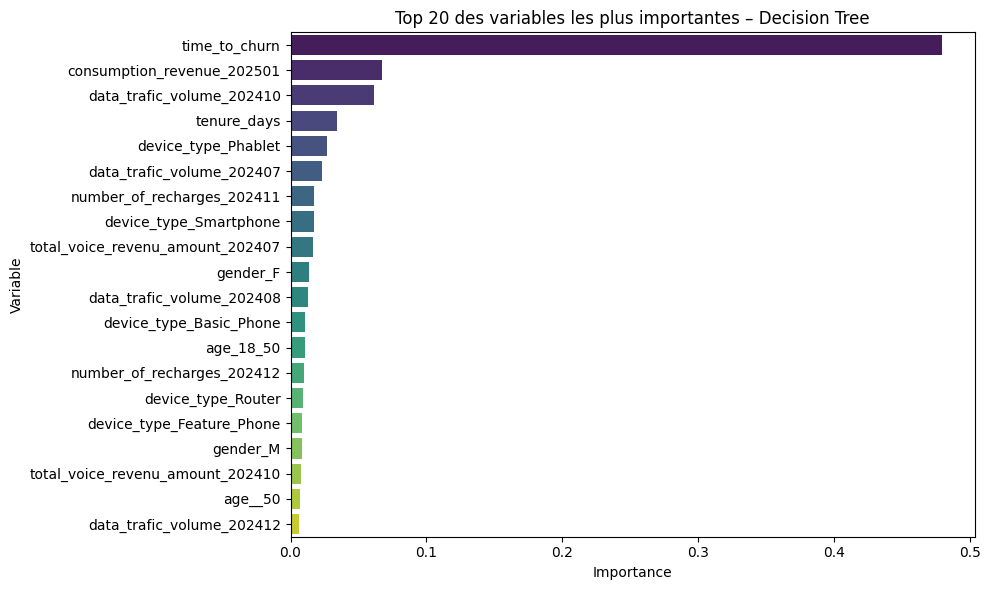

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Importances des variables ===
importances = dt_model.feature_importances_
feature_names = X.columns  # X = base d’origine sans "subscriber_id" ni "churn"
feat_imp_df = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(20)

# === Plot ===
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Variable", data=feat_imp_df, palette="viridis")
plt.title("Top 20 des variables les plus importantes – Decision Tree")
plt.tight_layout()
plt.show()


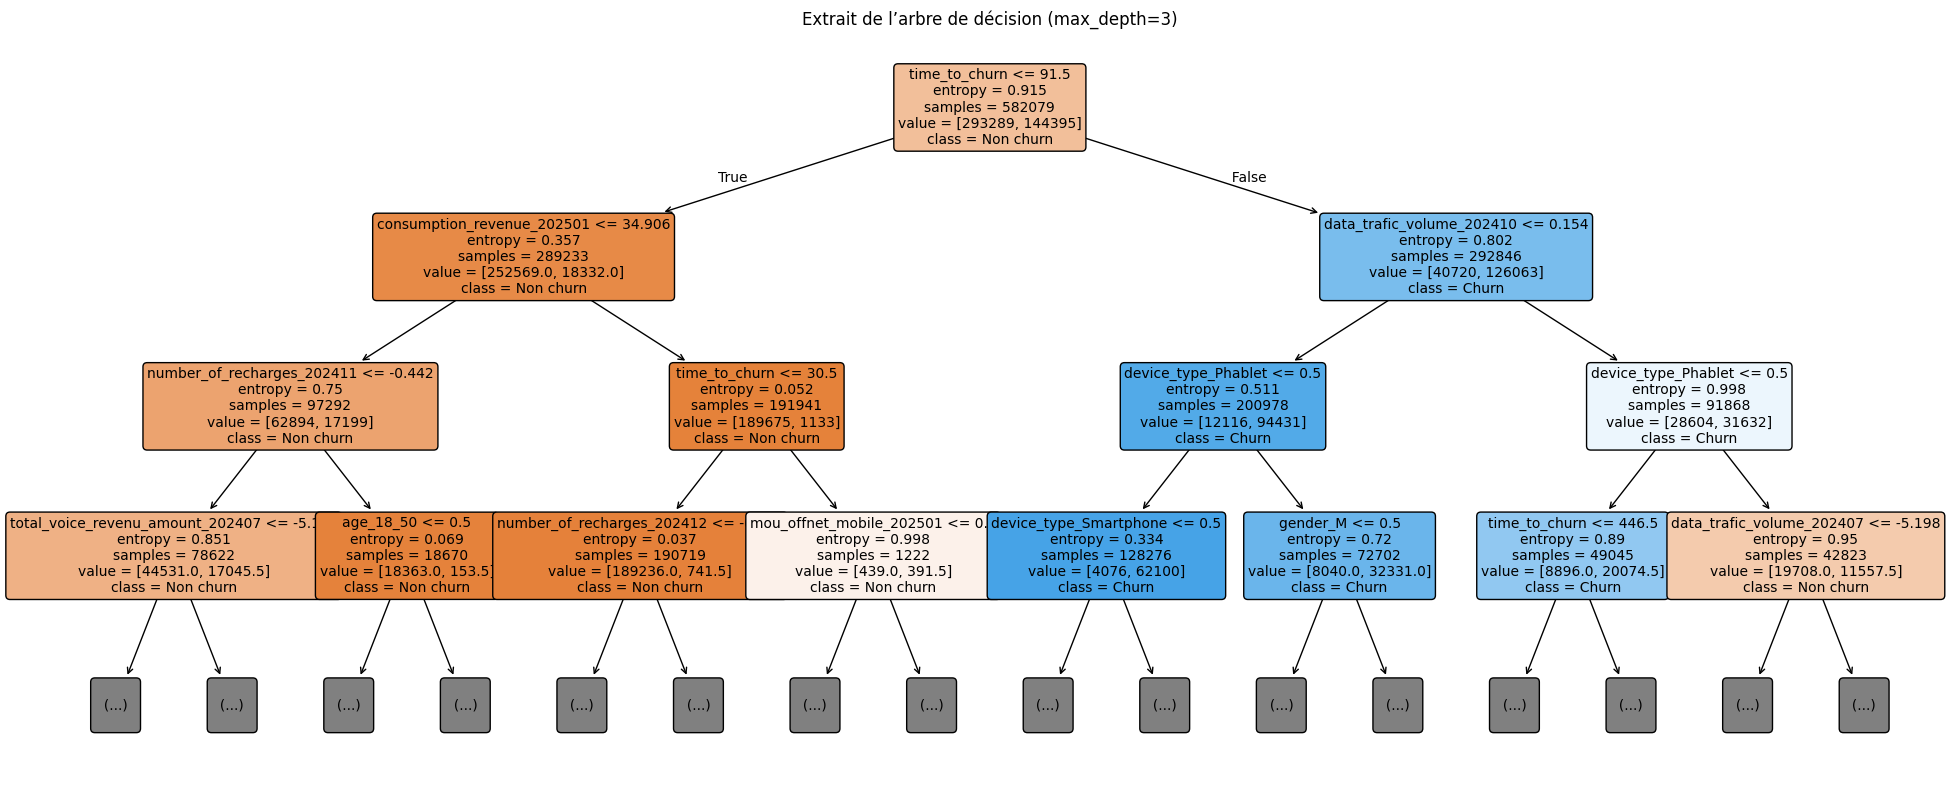

In [16]:
from sklearn.tree import plot_tree

# === Affichage partiel d’un arbre de décision ===
plt.figure(figsize=(20, 8))
plot_tree(
    dt_model,
    max_depth=3,            # Limiter la profondeur affichée
    feature_names=feature_names,
    class_names=["Non churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Extrait de l’arbre de décision (max_depth=3)")
plt.tight_layout()
plt.show()


📋 TRAIN:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    293289
           1       0.98      0.98      0.98    288790

    accuracy                           0.98    582079
   macro avg       0.98      0.98      0.98    582079
weighted avg       0.98      0.98      0.98    582079

📋 TEST:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     73323
           1       0.76      0.86      0.81      6359

    accuracy                           0.97     79682
   macro avg       0.87      0.92      0.89     79682
weighted avg       0.97      0.97      0.97     79682



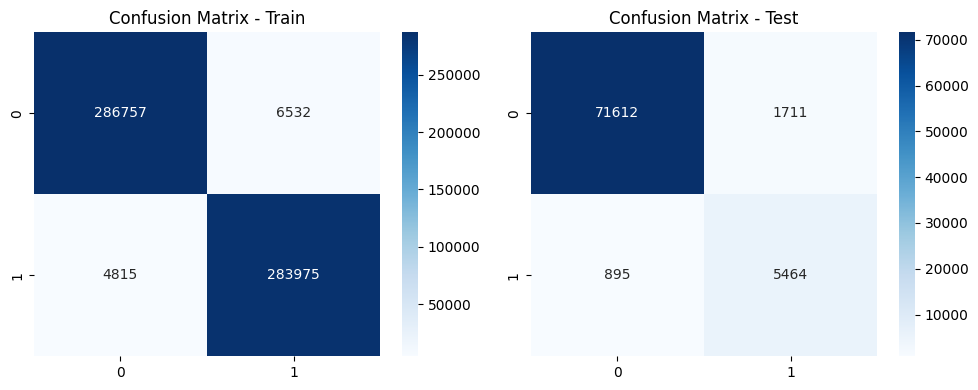

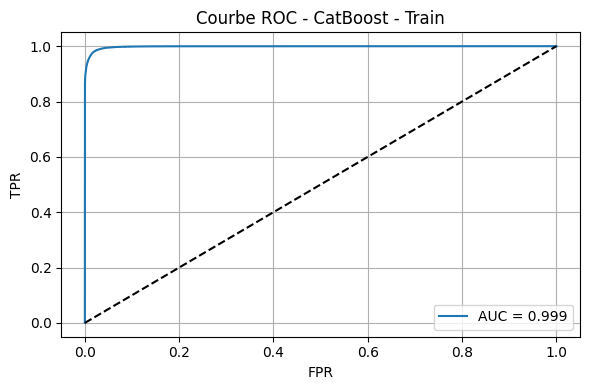

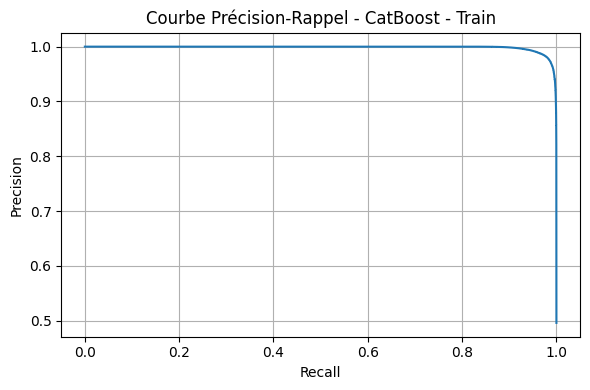

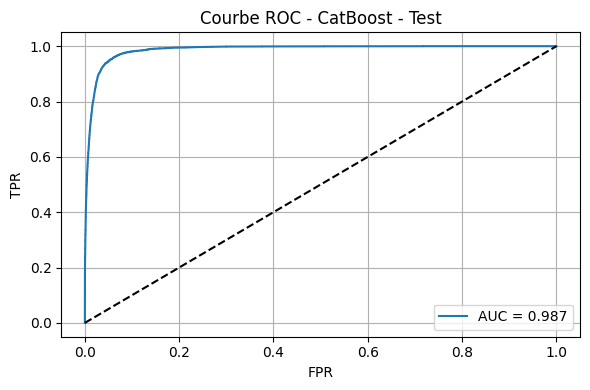

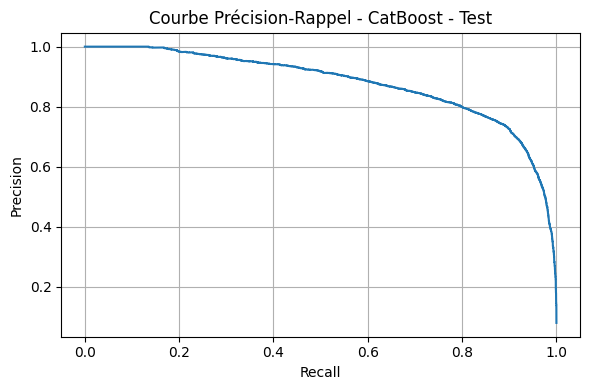

Courbe d'apprentissage: 100%|██████████| 9/9 [03:34<00:00, 23.84s/it]


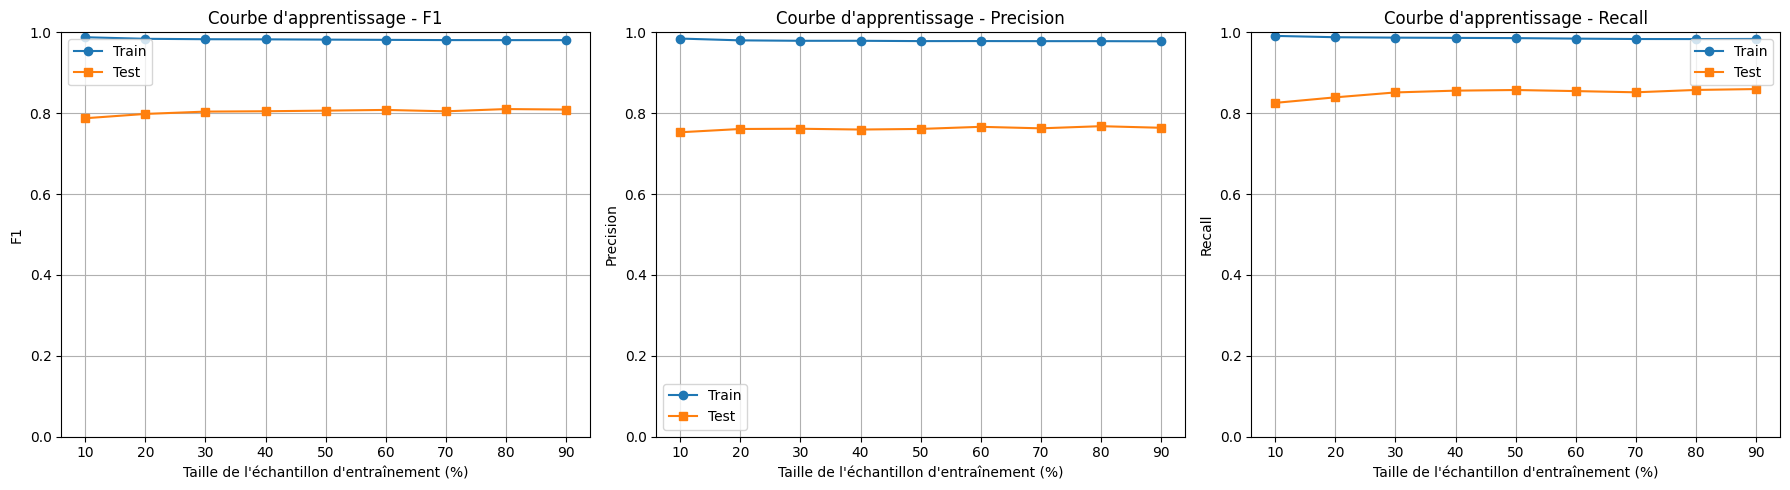

In [18]:
import re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import ADASYN
from tqdm import tqdm
from catboost import CatBoostClassifier

# === 1. Chargement des données ===
df = pd.read_csv("final_df_encoded.csv")
y = df["churn"]
X = df.drop(columns=["subscriber_id", "churn"])
X.columns = [re.sub(r"[^\w]", "_", col) for col in X.columns]

# === 2. Split stratifié ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === 3. Rééquilibrage avec ADASYN ===
adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train, y_train)

# === 4. Chargement et reconfiguration du modèle CatBoost ===
catboost_model = joblib.load("catboost_best_model.pkl")
params = catboost_model.get_params()
params.pop("verbose", None)
model = CatBoostClassifier(**params, verbose=0)
model.fit(X_train_bal, y_train_bal)

# === 5. Évaluation ===
y_proba_train = model.predict_proba(X_train_bal)[:, 1]
y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred_train = model.predict(X_train_bal)
y_pred_test = model.predict(X_test)

print("📋 TRAIN:\n", classification_report(y_train_bal, y_pred_train))
print("📋 TEST:\n", classification_report(y_test, y_pred_test))

# === 6. Matrices de confusion ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(confusion_matrix(y_train_bal, y_pred_train), annot=True, fmt="d", ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix - Train")
axes[1].set_title("Confusion Matrix - Test")
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", ax=axes[1], cmap="Blues")
plt.tight_layout()
plt.show()

# === 7. ROC et Précision-Rappel ===
def plot_roc_pr(y_true, y_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"Courbe ROC - {title}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.title(f"Courbe Précision-Rappel - {title}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_roc_pr(y_train_bal, y_proba_train, "CatBoost - Train")
plot_roc_pr(y_test, y_proba_test, "CatBoost - Test")

# === 8. Courbes d’apprentissage ===
train_sizes = np.linspace(0.1, 0.9, 9)
metrics = ["f1", "precision", "recall"]
scores = {m: {"train": [], "test": []} for m in metrics}

for frac in tqdm(train_sizes, desc="Courbe d'apprentissage"):
    X_sub, _, y_sub, _ = train_test_split(X_train, y_train, train_size=frac, stratify=y_train, random_state=42)
    X_res, y_res = adasyn.fit_resample(X_sub, y_sub)

    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_res, y_res)

    y_pred_tr = model.predict(X_res)
    y_pred_te = model.predict(X_test)

    for m in metrics:
        if m == "f1":
            scores[m]["train"].append(f1_score(y_res, y_pred_tr))
            scores[m]["test"].append(f1_score(y_test, y_pred_te))
        elif m == "precision":
            scores[m]["train"].append(precision_score(y_res, y_pred_tr))
            scores[m]["test"].append(precision_score(y_test, y_pred_te))
        elif m == "recall":
            scores[m]["train"].append(recall_score(y_res, y_pred_tr))
            scores[m]["test"].append(recall_score(y_test, y_pred_te))

# === 9. Affichage
plt.figure(figsize=(18, 5))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    plt.plot(train_sizes * 100, scores[metric]["train"], label="Train", marker="o")
    plt.plot(train_sizes * 100, scores[metric]["test"], label="Test", marker="s")
    plt.xlabel("Taille de l'échantillon d'entraînement (%)")
    plt.ylabel(metric.capitalize())
    plt.title(f"Courbe d'apprentissage - {metric.capitalize()}")
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()


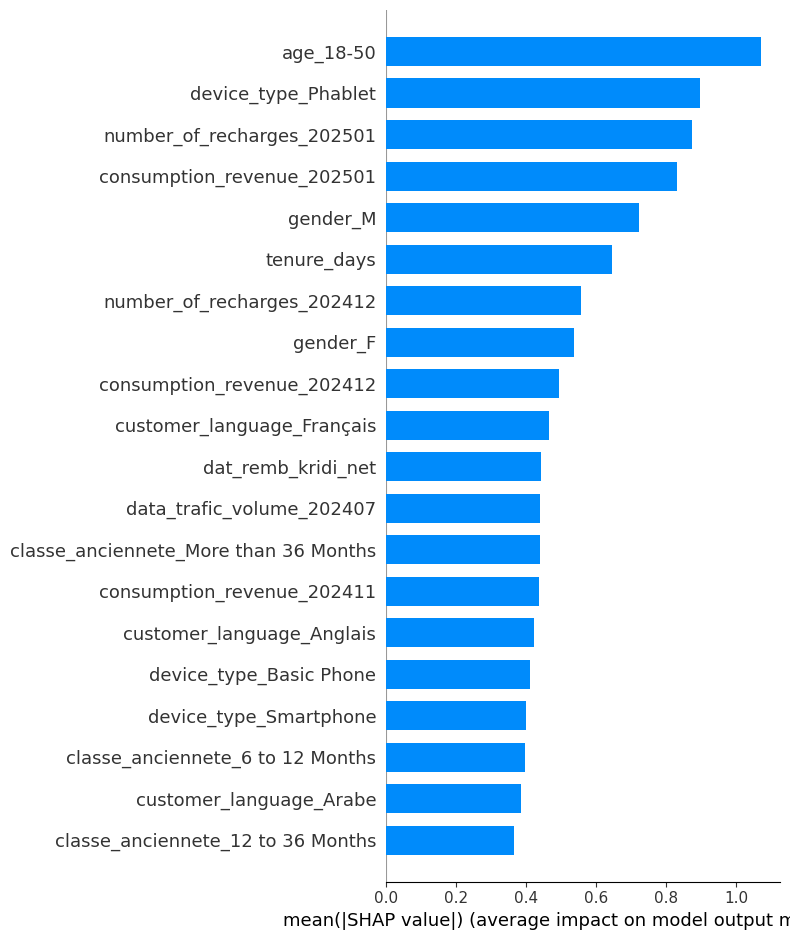

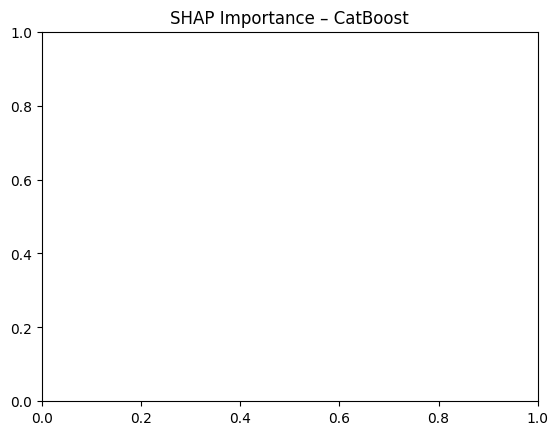

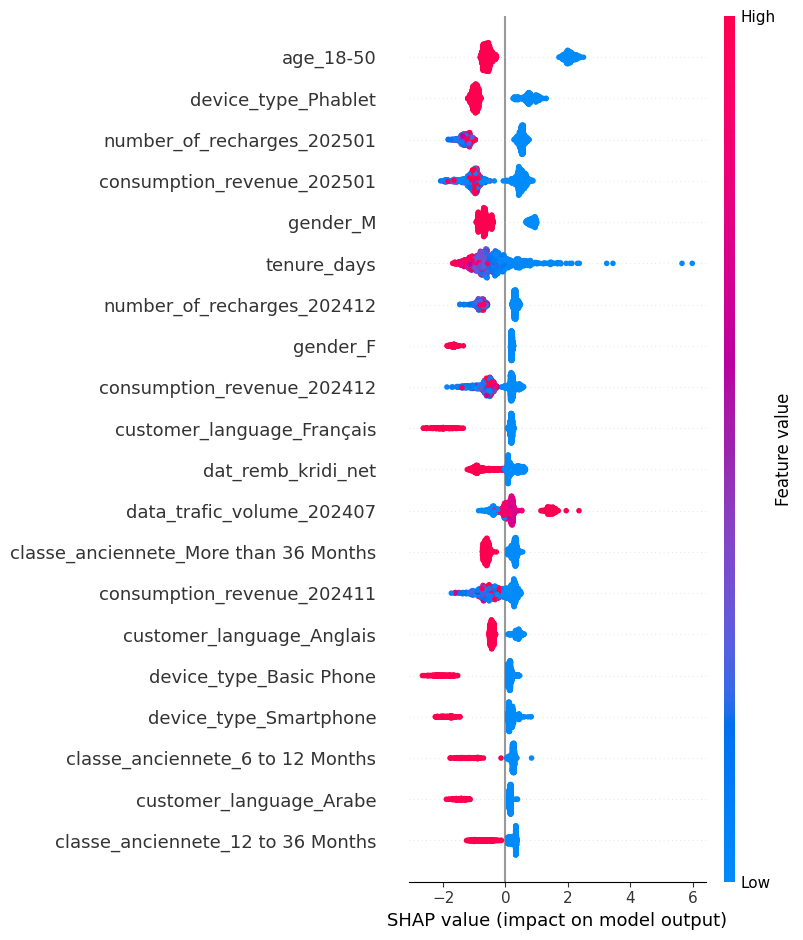

In [21]:
import shap
import pandas as pd
import joblib
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

# --- 1. Charger les objets nécessaires ---
model = joblib.load("catboost_best_model.pkl")
df = pd.read_csv("final_df_encoded.csv")  # Adapter selon ton fichier réel

# --- 2. Séparer les features et la cible ---
X = df.drop(columns=["subscriber_id", "churn"])
y = df["churn"]

# --- 3. Récupérer les noms des features attendues par le modèle ---
features_expected = model.feature_names_

# --- 4. Réindexer les colonnes : rajouter celles manquantes avec 0 ---
for col in features_expected:
    if col not in X.columns:
        X[col] = 0

X = X[features_expected]  # Réordonne les colonnes exactement

# --- 5. Échantillonner un sous-ensemble pour SHAP ---
X_sample = X.sample(n=1000, random_state=42)

# --- 6. Préparer le Pool CatBoost (nécessaire pour SHAP natif) ---
pool_sample = Pool(X_sample, feature_names=features_expected)

# --- 7. Créer l’explainer SHAP ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(pool_sample)

# --- 8. Afficher les graphiques SHAP ---
shap.summary_plot(shap_values, X_sample, plot_type="bar")
plt.title("SHAP Importance – CatBoost")
plt.show()

shap.summary_plot(shap_values, X_sample)


In [23]:
%pip install lime

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.8 MB 2.8 MB/s eta 0:00:05
   --- ------------------------------------ 1.0/12.8 MB 3.0 MB/s eta 0:00:04
   ---- ----------------------------------- 1.6/12.8 MB 3.0 MB/s eta 0:00:04
   ------- -------------------------------- 2.4/12.8 MB 2.9 MB/s eta 0:00:04
   --------- ------------------------------ 3.1/12.8 MB 3.1 MB/s eta 0:00:04
   ----------- ---------------------------- 3.7/12.8 MB 3.1 MB/s eta 0:00:03
   ------------ --------------------------- 3.9/12.8 MB 2.9 MB/s eta 0:00:04
   ------------- -------------------------- 4.2/12.8 MB 2.5 MB/s eta 0:00:04
   -------------- ------------------------- 4.7/12.8 MB 2.5 MB/s eta 0:00:04
   ---------------- ----------------------- 5.2/12.8 MB 2.5 MB/s eta 0:00:04
   ----------------- ---------------------- 5.5/12.8 MB 2.

  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [25]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# 1. Initialisation
explainer_lime = LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns.tolist(),
    class_names=['Non churn', 'Churn'],
    mode='classification'
)

# 2. Exemple individuel
i = 0  # ou tout autre index
exp = explainer_lime.explain_instance(
    data_row=X.iloc[i].values,
    predict_fn=model.predict_proba,
    num_features=10
)

# 3. Affichage texte (console)
print(f"Explication LIME pour l'individu #{i} :")
for feature, weight in exp.as_list():
    print(f"{feature} : {weight:.4f}")


Explication LIME pour l'individu #0 :
tenure_days <= 266.00 : 0.4288
0.00 < age_18-50 <= 1.00 : -0.1640
device_type_Phablet <= 0.00 : 0.1350
device_type_Router <= 0.00 : 0.1329
device_type_Tablet <= 0.00 : 0.1278
device_type_POS <= 0.00 : 0.1091
device_type_Mobile broadband PCI card <= 0.00 : 0.1063
customer_language_Italien <= 0.00 : -0.1043
marital_status_Veuf <= 0.00 : 0.0648
device_type_IoT Device <= 0.00 : 0.0585


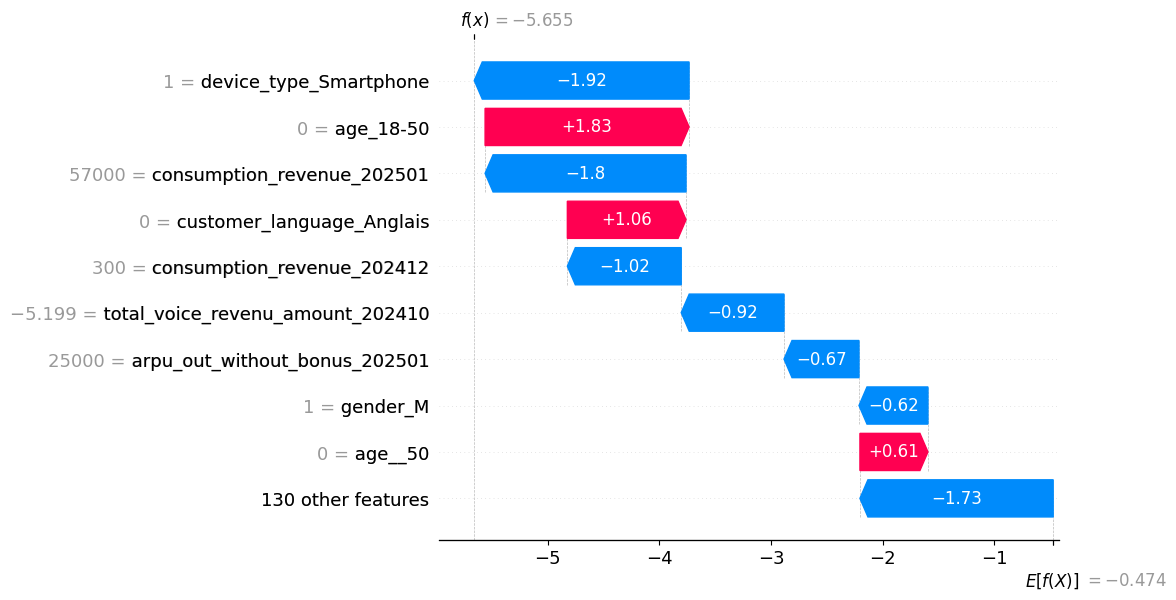

In [30]:
import pandas as pd
import shap
import joblib
import numpy as np
from catboost import Pool
import matplotlib.pyplot as plt

# 1. Charger le modèle CatBoost
model = joblib.load("catboost_best_model.pkl")
feature_names = model.feature_names_

# 2. Charger les données
df = pd.read_csv("final_df_encoded.csv")
X = df.drop(columns=["subscriber_id", "churn"], errors="ignore")
X.columns = X.columns.str.replace(r"[^A-Za-z0-9_]", "_", regex=True)  # Nettoyage standardisé

# 3. Ajouter les colonnes manquantes (si absentes du DataFrame)
for feat in feature_names:
    if feat not in X.columns:
        X[feat] = 0  # Valeur par défaut neutre (comme si feature inactive)

# 4. Réordonner les colonnes dans le même ordre que lors de l’entraînement
X = X[feature_names]

# 5. Sélectionner un individu
index = 0
x_instance = X.iloc[[index]]  # Important : double crochet pour garder le DataFrame

# 6. Construire le Pool CatBoost
x_pool = Pool(x_instance, feature_names=feature_names)

# 7. Créer l’explainer SHAP
explainer = shap.TreeExplainer(model)

# 8. Calcul des valeurs SHAP
shap_values = explainer.shap_values(x_pool)

# 9. Affichage du graphique Waterfall
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=x_instance.values[0],
    feature_names=feature_names
))


📋 Rapport de classification - Soft Voting:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     73323
           1       0.80      0.86      0.83      6359

    accuracy                           0.97     79682
   macro avg       0.89      0.92      0.91     79682
weighted avg       0.97      0.97      0.97     79682

🎯 AUC Score : 0.9883946158931768


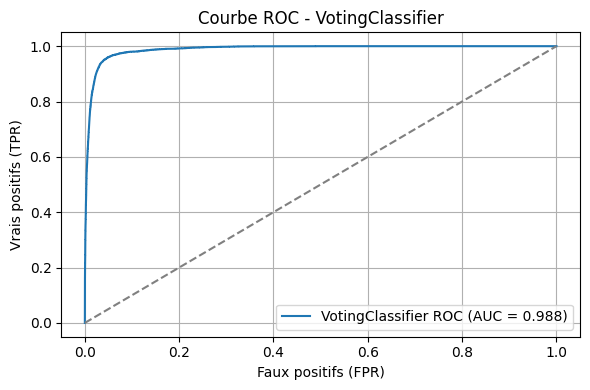

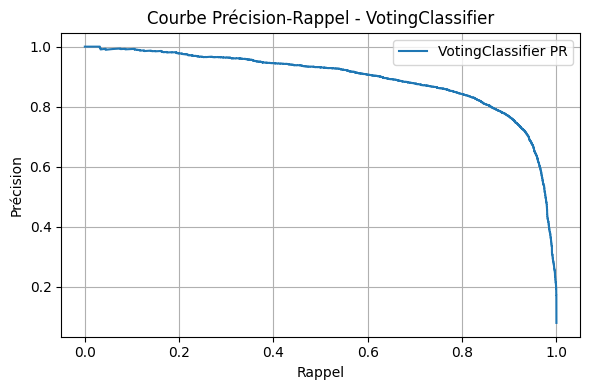

In [32]:
import pandas as pd
import numpy as np
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
# Assurez-vous d'installer imblearn s'il n'est pas installé : pip install imbalanced-learn
from imblearn.over_sampling import ADASYN

# --- 1. Chargement des données ---
df = pd.read_csv("final_df_encoded.csv")

# Séparer la cible et les features
y = df["churn"]
X = df.drop(columns=["subscriber_id", "churn"])

# --- 2. Nettoyage des noms de colonnes ---
# Remplacer tout ce qui n'est pas alphanumérique ou underscore par "_"
X.columns = [re.sub(r"[^\w]", "_", col) for col in X.columns]

# --- 3. Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# --- (Optionnel) Si un équilibrage est souhaité pour chaque modèle avant l'entraînement individuel,
# vous pouvez l'appliquer sur chaque modèle, mais ici le VotingClassifier sera entraîné sur X_train, y_train.

# --- 4. Chargement des modèles pré-entraînés ---
logreg_model     = joblib.load("logreg_model_optimal.pkl")
rf_model         = joblib.load("best_random_forest_model.pkl")
xgb_model        = joblib.load("xgb_model.pkl")
xgb_model.set_params(tree_method="hist", device="cpu")
lgb_model        = joblib.load("best_model_lgb.pkl")
dt_model         = joblib.load("best_decision_tree.pkl")
catboost_model   = joblib.load("catboost_best_model.pkl")

# --- 5. Création du VotingClassifier en mode soft voting ---
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg_model),
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('dt', dt_model),
        ('cat', catboost_model)
    ],
    voting='soft',
    n_jobs=-1
)

# --- 6. Entraînement sur le jeu d'entraînement ---
voting_clf.fit(X_train, y_train)

# --- 7. Prédictions et évaluation ---
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]

print("📋 Rapport de classification - Soft Voting:")
print(classification_report(y_test, y_pred))
print("🎯 AUC Score :", roc_auc_score(y_test, y_proba))

# --- 8. Tracé de la courbe ROC ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"VotingClassifier ROC (AUC = {roc_auc_score(y_test, y_proba):.3f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("Faux positifs (FPR)")
plt.ylabel("Vrais positifs (TPR)")
plt.title("Courbe ROC - VotingClassifier")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 9. Tracé de la courbe Précision-Rappel ---
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="VotingClassifier PR")
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbe Précision-Rappel - VotingClassifier")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📋 Rapport de classification - Soft Voting avec ADASYN:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     73323
           1       0.76      0.86      0.81      6359

    accuracy                           0.97     79682
   macro avg       0.88      0.92      0.89     79682
weighted avg       0.97      0.97      0.97     79682

🎯 AUC Score : 0.9863038124807006


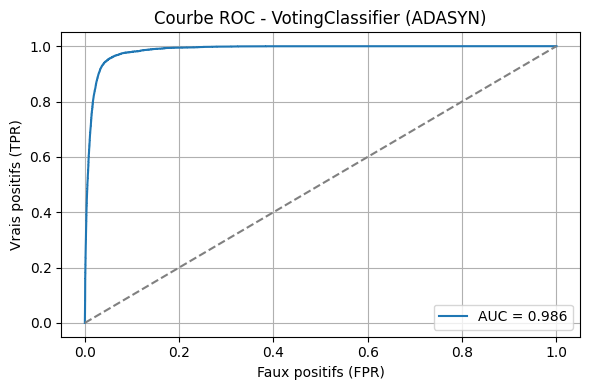

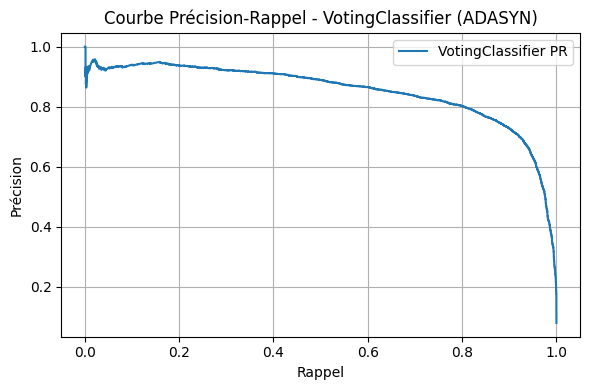

In [33]:
import pandas as pd
import numpy as np
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import ADASYN

# --- 1. Chargement des données ---
df = pd.read_csv("final_df_encoded.csv")

# Séparer la cible et les features
y = df["churn"]
X = df.drop(columns=["subscriber_id", "churn"])

# --- 2. Nettoyage des noms de colonnes ---
X.columns = [re.sub(r"[^\w]", "_", col) for col in X.columns]

# --- 3. Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# --- 4. Équilibrage ADASYN sur le training set ---
adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train, y_train)

# --- 5. Chargement des modèles pré-entraînés ---
logreg_model     = joblib.load("logreg_model_optimal.pkl")
rf_model         = joblib.load("best_random_forest_model.pkl")
xgb_model        = joblib.load("xgb_model.pkl")
xgb_model.set_params(tree_method="hist", device="cpu")
lgb_model        = joblib.load("best_model_lgb.pkl")
dt_model         = joblib.load("best_decision_tree.pkl")
catboost_model   = joblib.load("catboost_best_model.pkl")

# --- 6. Création du VotingClassifier ---
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg_model),
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('dt', dt_model),
        ('cat', catboost_model)
    ],
    voting='soft',
    n_jobs=-1
)

# --- 7. Entraînement sur données équilibrées ---
voting_clf.fit(X_train_bal, y_train_bal)

# --- 8. Prédictions et évaluation ---
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]

print("📋 Rapport de classification - Soft Voting avec ADASYN:")
print(classification_report(y_test, y_pred))
print("🎯 AUC Score :", roc_auc_score(y_test, y_proba))

# --- 9. Courbe ROC ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Faux positifs (FPR)")
plt.ylabel("Vrais positifs (TPR)")
plt.title("Courbe ROC - VotingClassifier (ADASYN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 10. Courbe Précision-Rappel ---
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label="VotingClassifier PR")
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbe Précision-Rappel - VotingClassifier (ADASYN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from lime.lime_tabular import LimeTabularExplainer

# === 1. Charger les données ===
df = pd.read_csv("final_df_encoded.csv")
X = df.drop(columns=["subscriber_id", "churn"])
y = df["churn"]

# Nettoyage des noms de colonnes pour correspondance
X.columns = X.columns.str.replace("<", "_", regex=False)
X.columns = X.columns.str.replace(">", "_", regex=False)
X.columns = X.columns.str.replace("-", "_", regex=False)

# === 2. Charger tous les modèles ===
logreg_model     = joblib.load("logreg_model_optimal.pkl")
rf_model         = joblib.load("best_random_forest_model.pkl")
xgb_model        = joblib.load("xgb_model.pkl")
lgb_model        = joblib.load("best_model_lgb.pkl")
dt_model         = joblib.load("best_decision_tree.pkl")
catboost_model   = joblib.load("catboost_best_model.pkl")

# === 3. Calcul du soft voting ===
probas = {
    "logreg": logreg_model.predict_proba(X)[:, 1],
    "rf":     rf_model.predict_proba(X)[:, 1],
    "xgb":    xgb_model.predict_proba(X)[:, 1],
    "lgb":    lgb_model.predict_proba(X)[:, 1],
    "dt":     dt_model.predict_proba(X)[:, 1],
    "cat":    catboost_model.predict_proba(X)[:, 1],
}

soft_vote_proba = np.mean(np.column_stack(list(probas.values())), axis=1)
soft_vote_pred = (soft_vote_proba >= 0.5).astype(int)

# === 4. Évaluation globale ===
print("=== Classification Report (Soft Voting) ===")
print(classification_report(y, soft_vote_pred))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y, soft_vote_pred))
print("\n=== ROC AUC Score ===")
print(roc_auc_score(y, soft_vote_proba))

# === 5. Interprétation LIME (individu 0) ===
explainer = LimeTabularExplainer(
    training_data=X.values,
    feature_names=X.columns.tolist(),
    class_names=["Not Churn", "Churn"],
    mode="classification"
)

idx = 0
lime_exp = explainer.explain_instance(
    data_row=X.iloc[idx].values,
    predict_fn=lambda x: np.column_stack([1 - soft_vote_proba[:x.shape[0]], soft_vote_proba[:x.shape[0]]])
)

lime_exp.show_in_notebook()


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- age_18_50
- age__18
- age__50
Feature names seen at fit time, yet now missing:
- age_18-50
- age_<18
- age_>50


In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import ADASYN
import numpy as np
import torch
import pandas as pd 
df=pd.read_csv("final_df_encoded.csv")
# Préparation des données
X_tab = df.drop(columns=['churn','subscriber_id'], axis=1).to_numpy().astype(np.float32)
y_tab = df['churn'].to_numpy().astype(int)


# Split train/test
X_train_tab, X_test_tab, y_train_tab, y_test_tab = train_test_split(
    X_tab, y_tab, test_size=0.2, random_state=42, stratify=y_tab
)
# Équilibrage des classes avec ADASYN
adasyn = ADASYN(random_state=42)
X_resampled_tab, y_resampled_tab = adasyn.fit_resample(X_train_tab, y_train_tab)
# Normalisation
scaler = StandardScaler()
X_resampled_tab = scaler.fit_transform(X_resampled_tab)
# Définition du modèle TabNet avec des hyperparamètres optimisés
clf = TabNetClassifier(
    n_d=32,                 # dimension des décisions
    n_a=32,                 # dimension des attentions
    n_steps=5,              # nombre de pas
    gamma=1.5,              # relaxation
    lambda_sparse=1e-4,     # régularisation
    optimizer_fn=torch.optim.Adam,  # optimiseur
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},  # scheduler
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',     # améliore l’interprétabilité (entmax > sparsemax)
    verbose=1,
    seed=42
)

# Apprentissage
clf.fit(
    X_train=X_train_tab, y_train=y_train_tab,
    eval_set=[(X_train_tab, y_train_tab), (X_test_tab, y_test_tab)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy', 'balanced_accuracy', 'auc'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Prédiction
y_pred_tab = clf.predict(X_test_tab)

# Rapport de classification
print(classification_report(y_test_tab, y_pred_tab))


d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.16304 | train_accuracy: 0.94519 | train_balanced_accuracy: 0.77212 | train_auc: 0.9642  | valid_accuracy: 0.94543 | valid_balanced_accuracy: 0.77302 | valid_auc: 0.96381 |  0:01:04s
epoch 1  | loss: 0.12305 | train_accuracy: 0.94727 | train_balanced_accuracy: 0.87589 | train_auc: 0.9708  | valid_accuracy: 0.94701 | valid_balanced_accuracy: 0.87563 | valid_auc: 0.97002 |  0:02:18s
epoch 2  | loss: 0.11673 | train_accuracy: 0.94767 | train_balanced_accuracy: 0.75424 | train_auc: 0.97069 | valid_accuracy: 0.94681 | valid_balanced_accuracy: 0.75115 | valid_auc: 0.97025 |  0:03:21s
epoch 3  | loss: 0.11307 | train_accuracy: 0.95265 | train_balanced_accuracy: 0.81996 | train_auc: 0.97371 | valid_accuracy: 0.95212 | valid_balanced_accuracy: 0.81758 | valid_auc: 0.97275 |  0:04:32s
epoch 4  | loss: 0.11049 | train_accuracy: 0.95409 | train_balanced_accuracy: 0.87163 | train_auc: 0.97457 | valid_accuracy: 0.95387 | valid_balanced_accuracy: 0.8711  | valid_auc: 0.97342 |  0:05

d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     73323
           1       0.80      0.78      0.79      6359

    accuracy                           0.97     79682
   macro avg       0.89      0.88      0.88     79682
weighted avg       0.97      0.97      0.97     79682



In [2]:
# Sauvegarde du modèle
clf.save_model("tabnet_churn_model")


Successfully saved model at tabnet_churn_model.zip


'tabnet_churn_model.zip'

Epoch 1/30
1834/1834 - 4s - 2ms/step - accuracy: 0.0041 - loss: 0.5287 - precision: 0.7284 - recall: 0.7973 - val_accuracy: 0.0000e+00 - val_loss: 0.5190 - val_precision: 1.0000 - val_recall: 0.8821
Epoch 2/30
1834/1834 - 3s - 2ms/step - accuracy: 6.0734e-04 - loss: 0.3548 - precision: 0.7481 - recall: 0.9359 - val_accuracy: 0.0000e+00 - val_loss: 0.3797 - val_precision: 1.0000 - val_recall: 0.9590
Epoch 3/30
1834/1834 - 3s - 2ms/step - accuracy: 4.1555e-04 - loss: 0.3202 - precision: 0.7609 - recall: 0.9544 - val_accuracy: 0.0000e+00 - val_loss: 0.3739 - val_precision: 1.0000 - val_recall: 0.9338
Epoch 4/30
1834/1834 - 3s - 2ms/step - accuracy: 1.2147e-04 - loss: 0.3075 - precision: 0.7724 - recall: 0.9518 - val_accuracy: 0.0000e+00 - val_loss: 0.3455 - val_precision: 1.0000 - val_recall: 0.9543
Epoch 5/30
1834/1834 - 3s - 2ms/step - accuracy: 1.2786e-05 - loss: 0.3075 - precision: 0.7779 - recall: 0.9482 - val_accuracy: 0.0000e+00 - val_loss: 0.3529 - val_precision: 1.0000 - val_reca

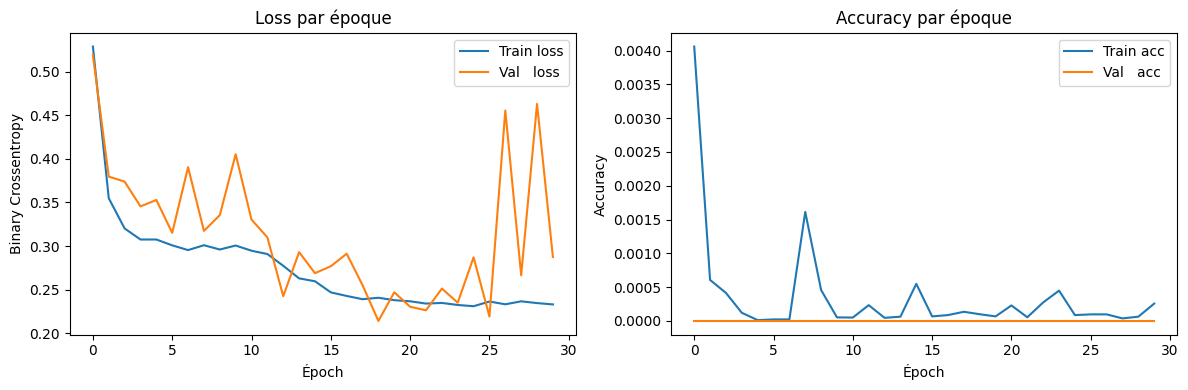

2491/2491 ━━━━━━━━━━━━━━━━━━━━ 2s 758us/step

Classification report (test):
              precision    recall  f1-score   support

           0     0.9898    0.9068    0.9465     73323
           1     0.4537    0.8924    0.6016      6359

    accuracy                         0.9057     79682
   macro avg     0.7218    0.8996    0.7741     79682
weighted avg     0.9470    0.9057    0.9190     79682



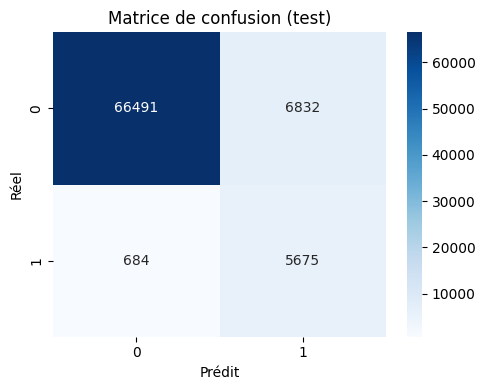

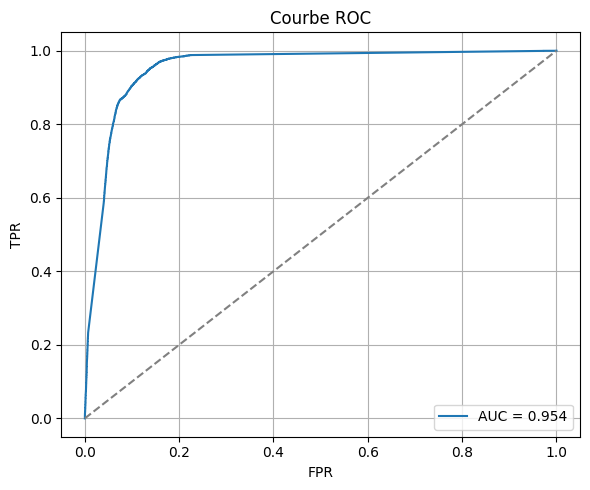

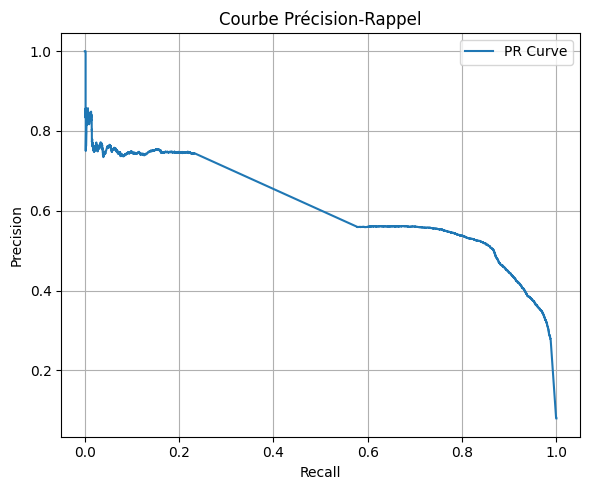

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve, classification_report
)
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

# ─── 0) Charger vos données ─────────────────────────────────────────────────────
df = pd.read_csv("final_df_encoded.csv")
X = df.drop(columns=["subscriber_id","churn"])
y = df["churn"].values

# ─── 1) Split train / test ──────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ─── 2) Rééquilibrage du train par SMOTE ────────────────────────────────────────
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ─── 3) Calcul des class weights (optionnel si vous voulez aussi en plus du SMOTE) ─
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_res),
    y=y_train_res
)
class_weights = {i: cw_val for i, cw_val in enumerate(cw)}

# ─── 4) Charger le modèle et compiler ────────────────────────────────────────────
model = load_model("modele_churn_prediction.keras")


# ─── 5) Entraîner en conservant l’historique ────────────────────────────────────
history = model.fit(
    X_train_res, y_train_res,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    class_weight=class_weights,   # <-- prend en compte le déséquilibre
    verbose=2
)

# ─── 6) Tracer les courbes d’apprentissage ───────────────────────────────────────
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(history.history["loss"],    label="Train loss")
axes[0].plot(history.history["val_loss"],label="Val   loss")
axes[0].set_title("Loss par époque");    axes[0].set_xlabel("Époch"); axes[0].set_ylabel("Binary Crossentropy"); axes[0].legend()

axes[1].plot(history.history["accuracy"],    label="Train acc")
axes[1].plot(history.history["val_accuracy"],label="Val   acc")
axes[1].set_title("Accuracy par époque"); axes[1].set_xlabel("Époch"); axes[1].set_ylabel("Accuracy"); axes[1].legend()

plt.tight_layout()
plt.show()

# ─── 7) Évaluation finale sur le jeu de test ────────────────────────────────────
y_proba = model.predict(X_test).ravel()
y_pred  = (y_proba >= 0.5).astype(int)

print("\nClassification report (test):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.title("Matrice de confusion (test)"); plt.xlabel("Prédit"); plt.ylabel("Réel"); plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc     = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("Courbe ROC"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(loc="lower right"); plt.grid(True); plt.tight_layout()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label="PR Curve")
plt.title("Courbe Précision-Rappel"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
910/910 - 7s - 8ms/step - accuracy: 0.9340 - auc: 0.9862 - loss: 0.1491 - val_accuracy: 0.9573 - val_auc: 0.9948 - val_loss: 0.0954
Epoch 2/50
910/910 - 4s - 4ms/step - accuracy: 0.9553 - auc: 0.9933 - loss: 0.1025 - val_accuracy: 0.9600 - val_auc: 0.9955 - val_loss: 0.0892
Epoch 3/50
910/910 - 4s - 5ms/step - accuracy: 0.9590 - auc: 0.9942 - loss: 0.0950 - val_accuracy: 0.9649 - val_auc: 0.9957 - val_loss: 0.0825
Epoch 4/50
910/910 - 4s - 4ms/step - accuracy: 0.9605 - auc: 0.9946 - loss: 0.0915 - val_accuracy: 0.9652 - val_auc: 0.9960 - val_loss: 0.0794
Epoch 5/50
910/910 - 4s - 4ms/step - accuracy: 0.9620 - auc: 0.9949 - loss: 0.0885 - val_accuracy: 0.9661 - val_auc: 0.9961 - val_loss: 0.0778
Epoch 6/50
910/910 - 4s - 4ms/step - accuracy: 0.9629 - auc: 0.9952 - loss: 0.0859 - val_accuracy: 0.9676 - val_auc: 0.9963 - val_loss: 0.0760
Epoch 7/50
910/910 - 4s - 5ms/step - accuracy: 0.9639 - auc: 0.9954 - loss: 0.0842 - val_accuracy: 0.9684 - val_auc: 0.9964 - val_loss: 0.0740

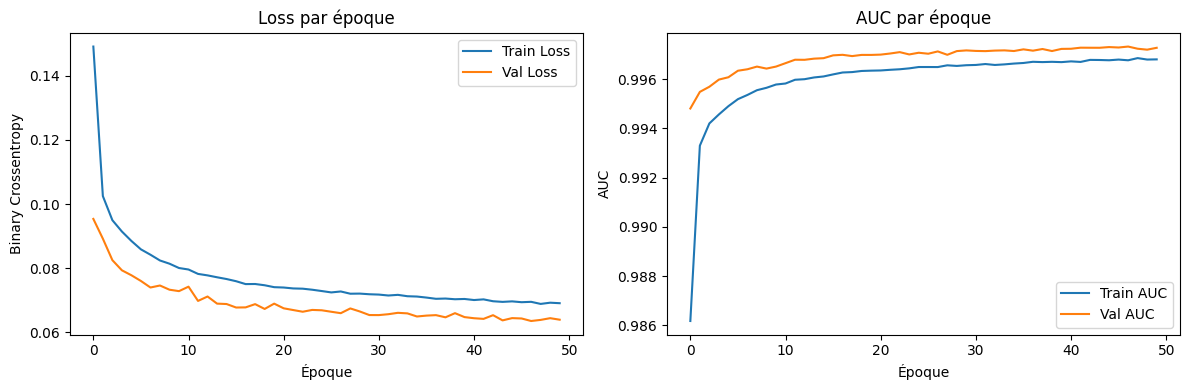

2491/2491 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
📋 Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9882    0.9625    0.9751     73323
           1     0.6670    0.8671    0.7540      6359

    accuracy                         0.9548     79682
   macro avg     0.8276    0.9148    0.8646     79682
weighted avg     0.9625    0.9548    0.9575     79682



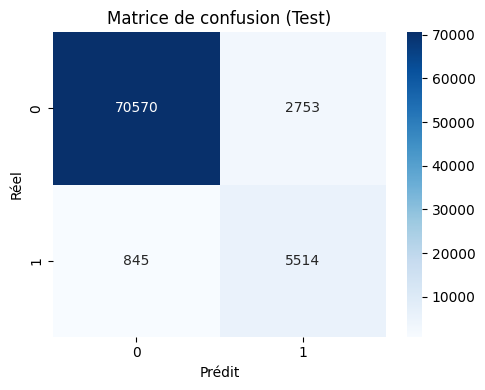

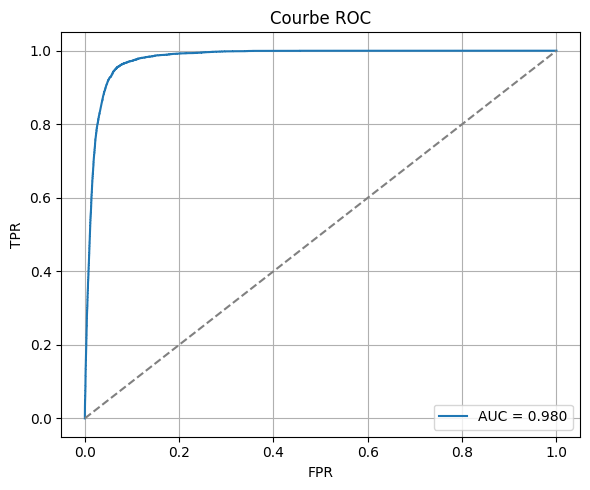

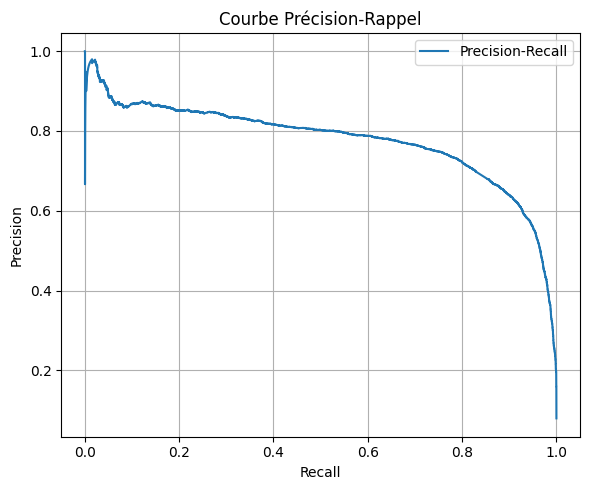

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# ─── 0) Charger les données ─────────────────────────────────────────────────────
df = pd.read_csv("final_df_encoded.csv")
X = df.drop(columns=["subscriber_id", "churn"])
y = df["churn"].values

# ─── 1) Split train / test ──────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ─── 2) SMOTE sur le train ──────────────────────────────────────────────────────
smote = ADASYN(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ─── 3) Split train / validation ────────────────────────────────────────────────
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_res, y_train_res,
    test_size=0.20,
    stratify=y_train_res,
    random_state=42
)

# ─── 4) Normalisation ───────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ─── 5) Construction du modèle ─────────────────────────────────────────────────
model = Sequential([
    Dense(128, input_shape=(X.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# ─── 6) Compilation ────────────────────────────────────────────────────────────
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# ─── 7) Callbacks ──────────────────────────────────────────────────────────────
early_stop = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=7,
    restore_best_weights=True
)

# ─── 8) Entraînement ───────────────────────────────────────────────────────────
history = model.fit(
    X_train_scaled, y_train_split,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=512,
    callbacks=[early_stop],
    verbose=2
)

# ─── 9) Courbes d’apprentissage ────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Loss par époque')
axes[0].set_xlabel('Époque')
axes[0].set_ylabel('Binary Crossentropy')
axes[0].legend()

axes[1].plot(history.history['auc'], label='Train AUC')
axes[1].plot(history.history['val_auc'], label='Val AUC')
axes[1].set_title('AUC par époque')
axes[1].set_xlabel('Époque')
axes[1].set_ylabel('AUC')
axes[1].legend()

plt.tight_layout()
plt.show()

# ─── 10) Évaluation finale ─────────────────────────────────────────────────────
y_proba = model.predict(X_test_scaled).ravel()
y_pred  = (y_proba >= 0.5).astype(int)

print("📋 Classification Report (Test):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1], yticklabels=[0,1])
plt.title("Matrice de confusion (Test)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

# ─── 11) Courbe ROC & AUC ───────────────────────────────────────────────────────
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc     = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("Courbe ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# ─── 12) Courbe Précision-Rappel ────────────────────────────────────────────────
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label='Precision-Recall')
plt.title("Courbe Précision-Rappel")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
import joblib

# 1. Save the Keras model (Recommended: .keras format)
model.save("churn_nn_model_optimized.keras")

d:\pfe Ooreedo\pfe\.venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


📋 Rapport de classification (TabNet) :
              precision    recall  f1-score   support

           0     0.9807    0.9830    0.9819     73323
           1     0.7989    0.7772    0.7879      6359

    accuracy                         0.9666     79682
   macro avg     0.8898    0.8801    0.8849     79682
weighted avg     0.9662    0.9666    0.9664     79682



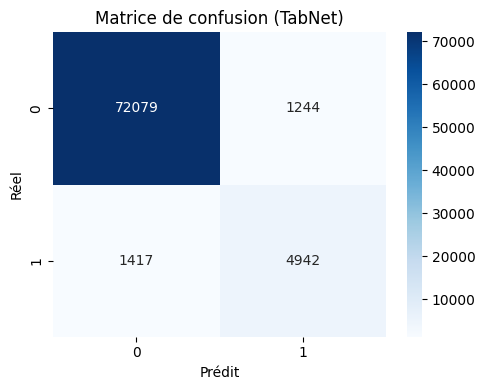

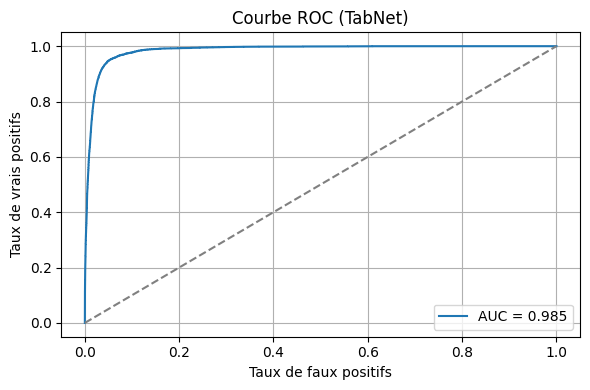

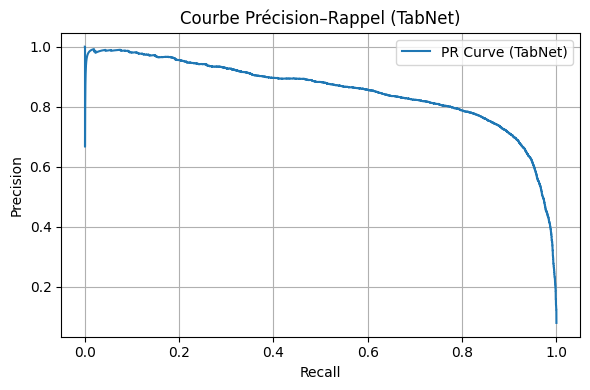

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve
)
from imblearn.over_sampling import ADASYN
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# ─── 0) Charger les données ─────────────────────────────────────────────────────
df = pd.read_csv("final_df_encoded.csv")
X = df.drop(columns=['subscriber_id','churn'], axis=1).to_numpy().astype(np.float32)
y = df['churn'].to_numpy().astype(int)

# ─── 1) Split train/test ──────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ─── 2) Rééquilibrage ADASYN sur l'entraînement ──────────────────────────────────
adasyn = ADASYN(random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)


# ─── 7) (Re)chargement du modèle pour l’évaluation ───────────────────────────────
loaded_clf = TabNetClassifier()         # il faut recréer une instance vide
loaded_clf.load_model("tabnet_churn_model.zip")  # charge le .zip créé

# ─── 8) Prédictions et probabilités ─────────────────────────────────────────────
y_proba = loaded_clf.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

# ─── 9) Rapport de classification ────────────────────────────────────────────────
print("📋 Rapport de classification (TabNet) :")
print(classification_report(y_test, y_pred, digits=4))

# ─── 10) Matrice de confusion ───────────────────────────────────────────────────
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1], yticklabels=[0,1])
plt.title("Matrice de confusion (TabNet)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

# ─── 11) Courbe ROC ──────────────────────────────────────────────────────────────
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc     = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("Courbe ROC (TabNet)")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ─── 12) Courbe Précision–Rappel ────────────────────────────────────────────────
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="PR Curve (TabNet)")
plt.title("Courbe Précision–Rappel (TabNet)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

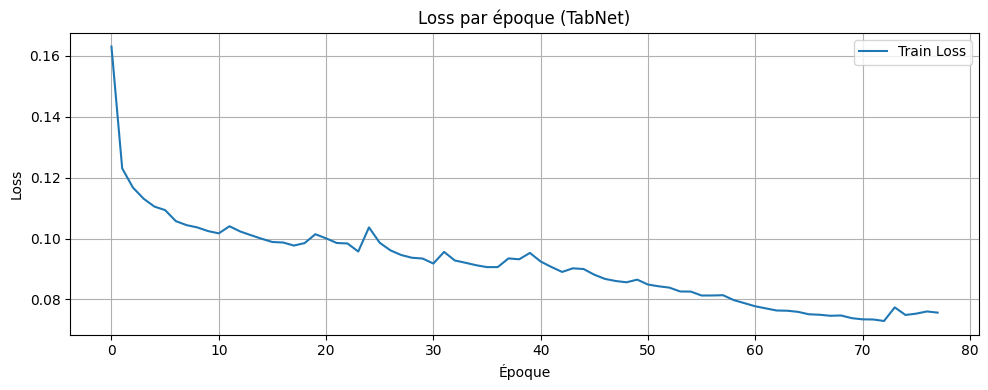

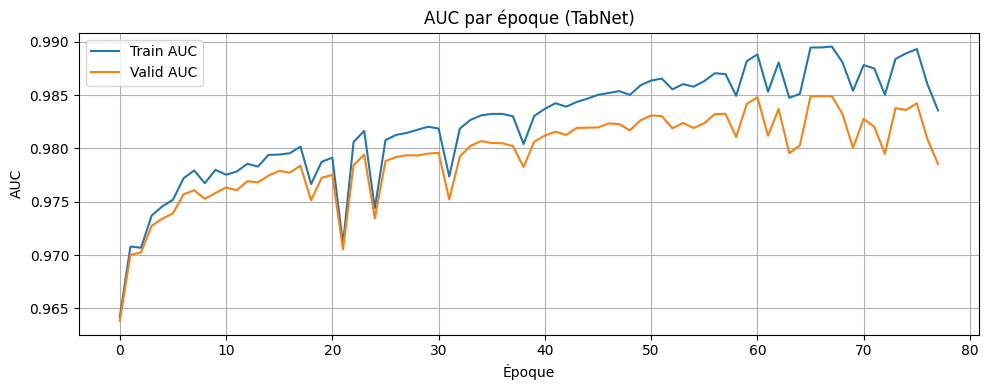

In [11]:
# ─── 6bis) Récupérer l’historique d’entraînement ────────────────────────────────
# (à placer juste après le fit(), avant save_model())
history = clf.history

# Les keys disponibles sont par exemple :
#   history["loss"]        : liste des loss d’entraînement par époque
#   history["train_auc"]   : liste des AUC d’entraînement par époque
#   history["valid_auc"]   : liste des AUC de validation par époque

# ─── 6ter) Tracer les courbes d’apprentissage ─────────────────────────────────
import matplotlib.pyplot as plt

# 1) Loss par époque
plt.figure(figsize=(10,4))
plt.plot(history["loss"], label="Train Loss")
# s’il existait une validation loss, par exemple history["valid_loss"], on la tracerait ici :
# plt.plot(history["valid_loss"], label="Valid Loss")
plt.title("Loss par époque (TabNet)")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) AUC par époque
plt.figure(figsize=(10,4))
plt.plot(history["train_auc"], label="Train AUC")
plt.plot(history["valid_auc"], label="Valid AUC")
plt.title("AUC par époque (TabNet)")
plt.xlabel("Époque")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
